# Context
This notebook drives the training process for different models.

In [1]:
# Set project's environment variables
import os
import sys
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../project.env")
sys.path.append(os.environ["PYTHONPATH"])

In [2]:
# Import project-wide and PH2 specific variables and functions
import superheader as sup
import TRAIN.architecture.KNN.knn as knn

# Models

## Setup

In [3]:
import gc

In [ ]:
TRAIN_CLASSES = "two-classes"
num_classes = 2 
num_class_candidates = list(range(2, num_classes+1, 1))

In [5]:
import json
with open(os.path.join(sup.DATA_ROOT, f"{TRAIN_CLASSES}-subsets.json"), "r") as f:
    loaded = json.load(f)

# Convert keys back to int and lists back to tuples
subsets = {
    int(k): {d: v for d, v in v_dict.items()}
    for k, v_dict in loaded.items()
}
subsets


{2: {'easy': [0, 1], 'average': [0, 1], 'hard': [0, 1]}}

In [ ]:
base_data_config = {
  "PH3" : False,
  "reducer" : '',
  "kernel" : '',
  "label_col" : sup.class_numeric_column,
  "class_list" : 'specified'
}

base_train_config = {
  "arch" : sup.TRAIN_KNN_CODE,
  "k" : 1
}



## Train

In [7]:
metric_tracker = list()

{'PH3': False, 'reducer': '', 'kernel': '', 'label_col': 'class_numeric', 'class_list': 'specified', 'data_unit': 'Spf', 'PH2': False, 'n': 72, 'difficulty': 'easy', 'class_numeric_list': [0, 1]}
{'arch': 'KNN', 'k': 1}
0.98828125
1
0.9882667481475823
0.9884161623571123
0.988147605083089
clearing memory...
{'PH3': False, 'reducer': '', 'kernel': '', 'label_col': 'class_numeric', 'class_list': 'specified', 'data_unit': 'Spf', 'PH2': False, 'n': 72, 'difficulty': 'average', 'class_numeric_list': [0, 1]}
{'arch': 'KNN', 'k': 1}
0.98828125
1
0.9882667481475823
0.9884161623571123
0.988147605083089
clearing memory...
{'PH3': False, 'reducer': '', 'kernel': '', 'label_col': 'class_numeric', 'class_list': 'specified', 'data_unit': 'Spf', 'PH2': False, 'n': 72, 'difficulty': 'hard', 'class_numeric_list': [0, 1]}
{'arch': 'KNN', 'k': 1}
0.98828125
1
0.9882667481475823
0.9884161623571123
0.988147605083089
clearing memory...
{'PH3': False, 'reducer': '', 'kernel': '', 'label_col': 'class_numeric',

0

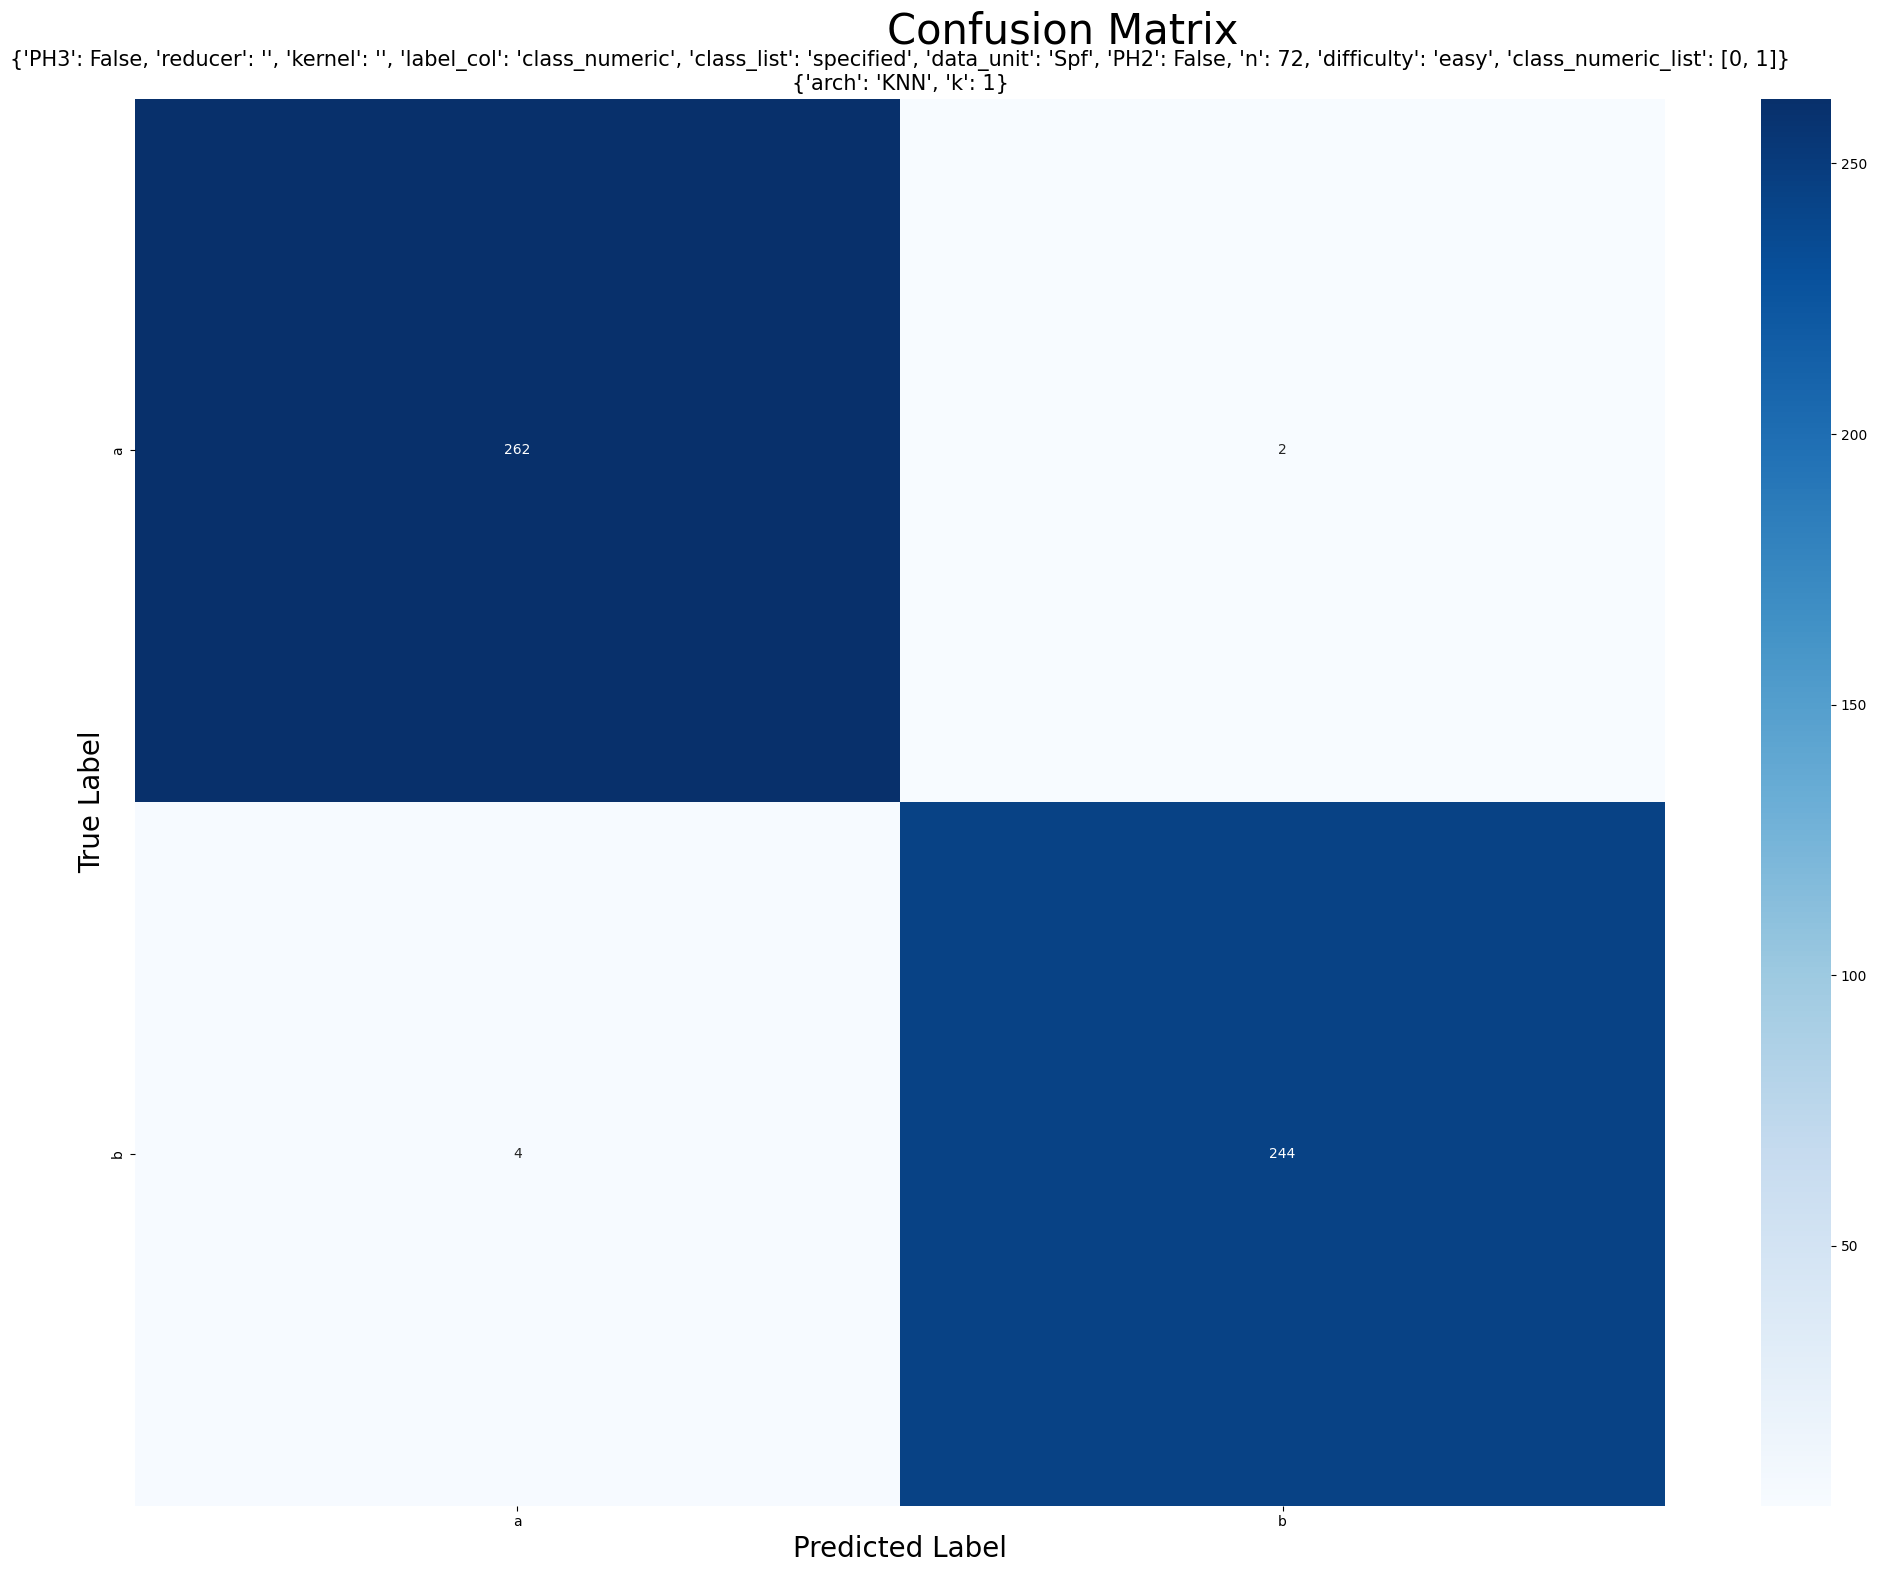

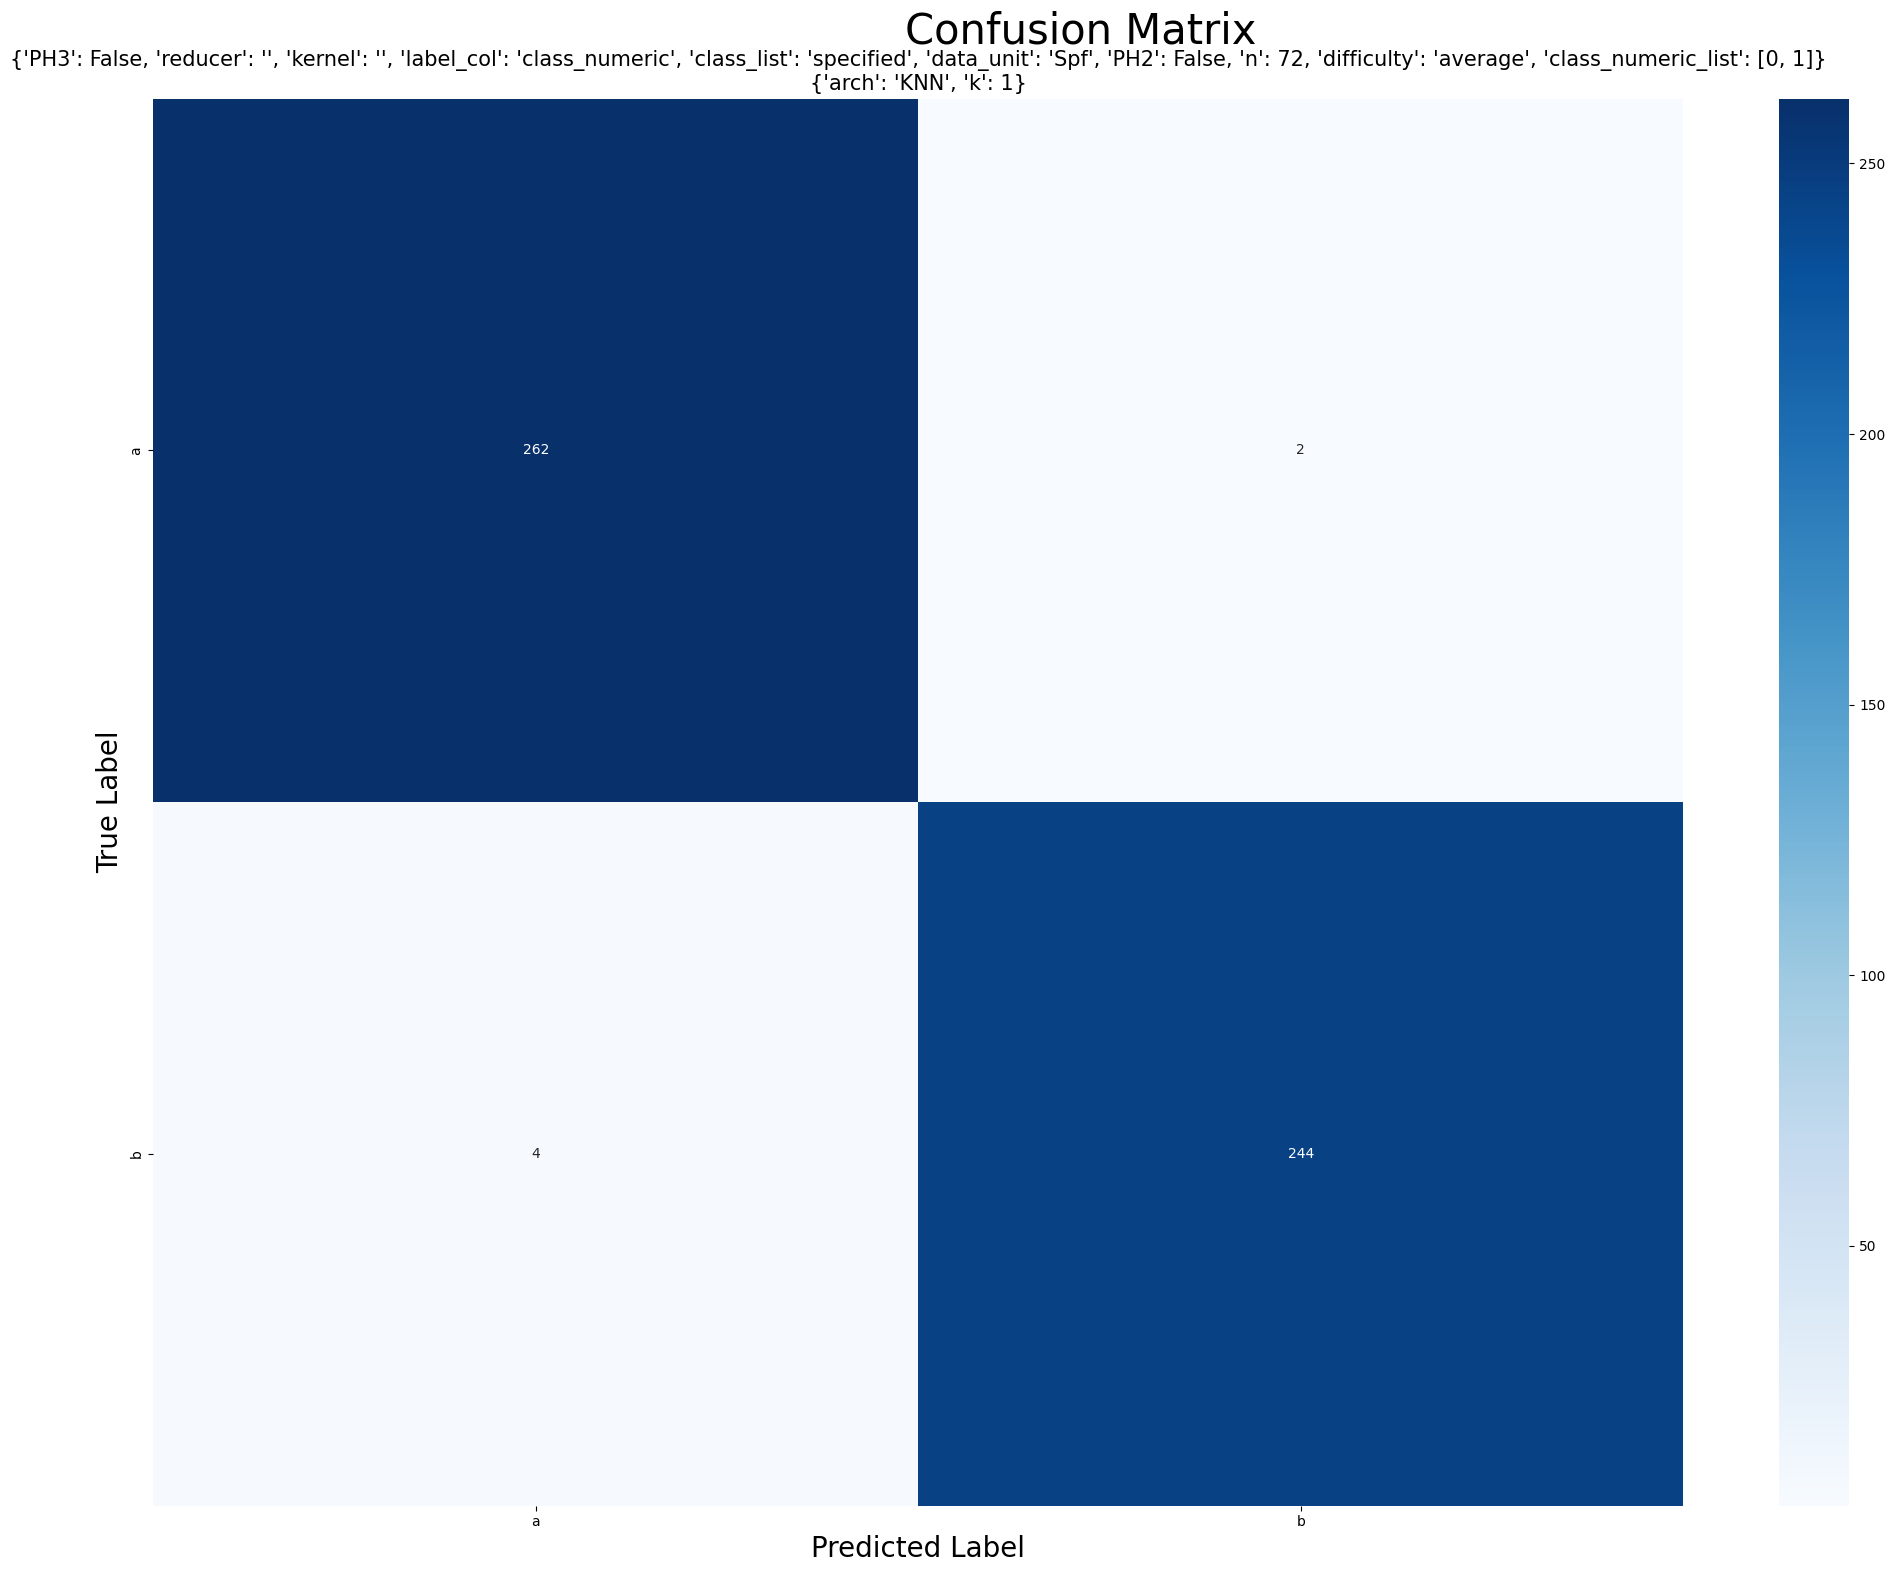

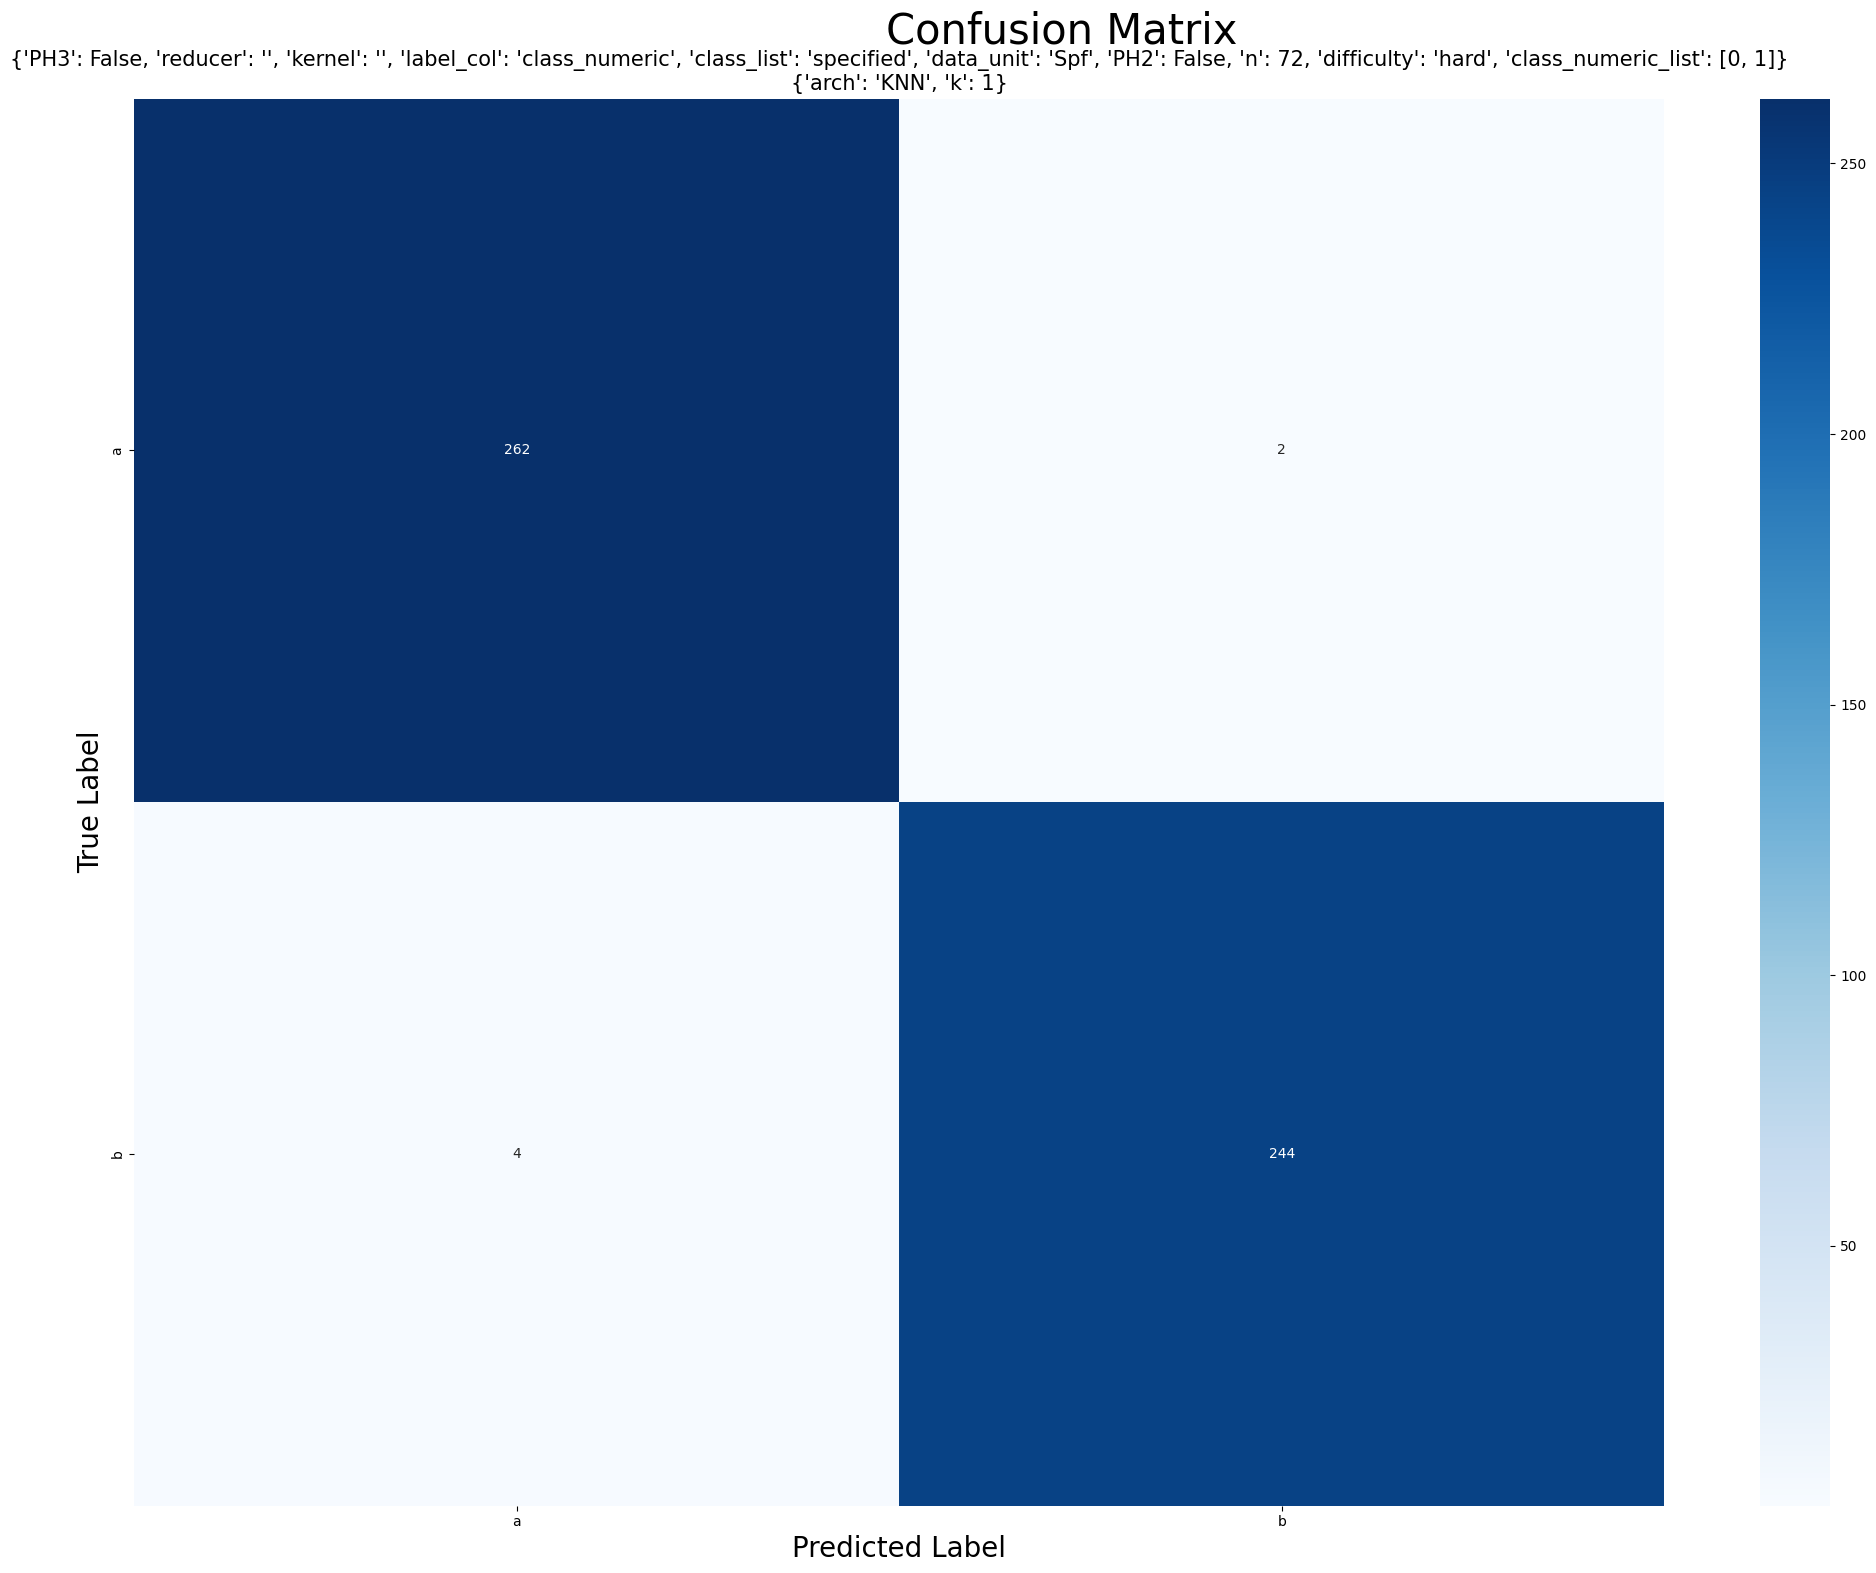

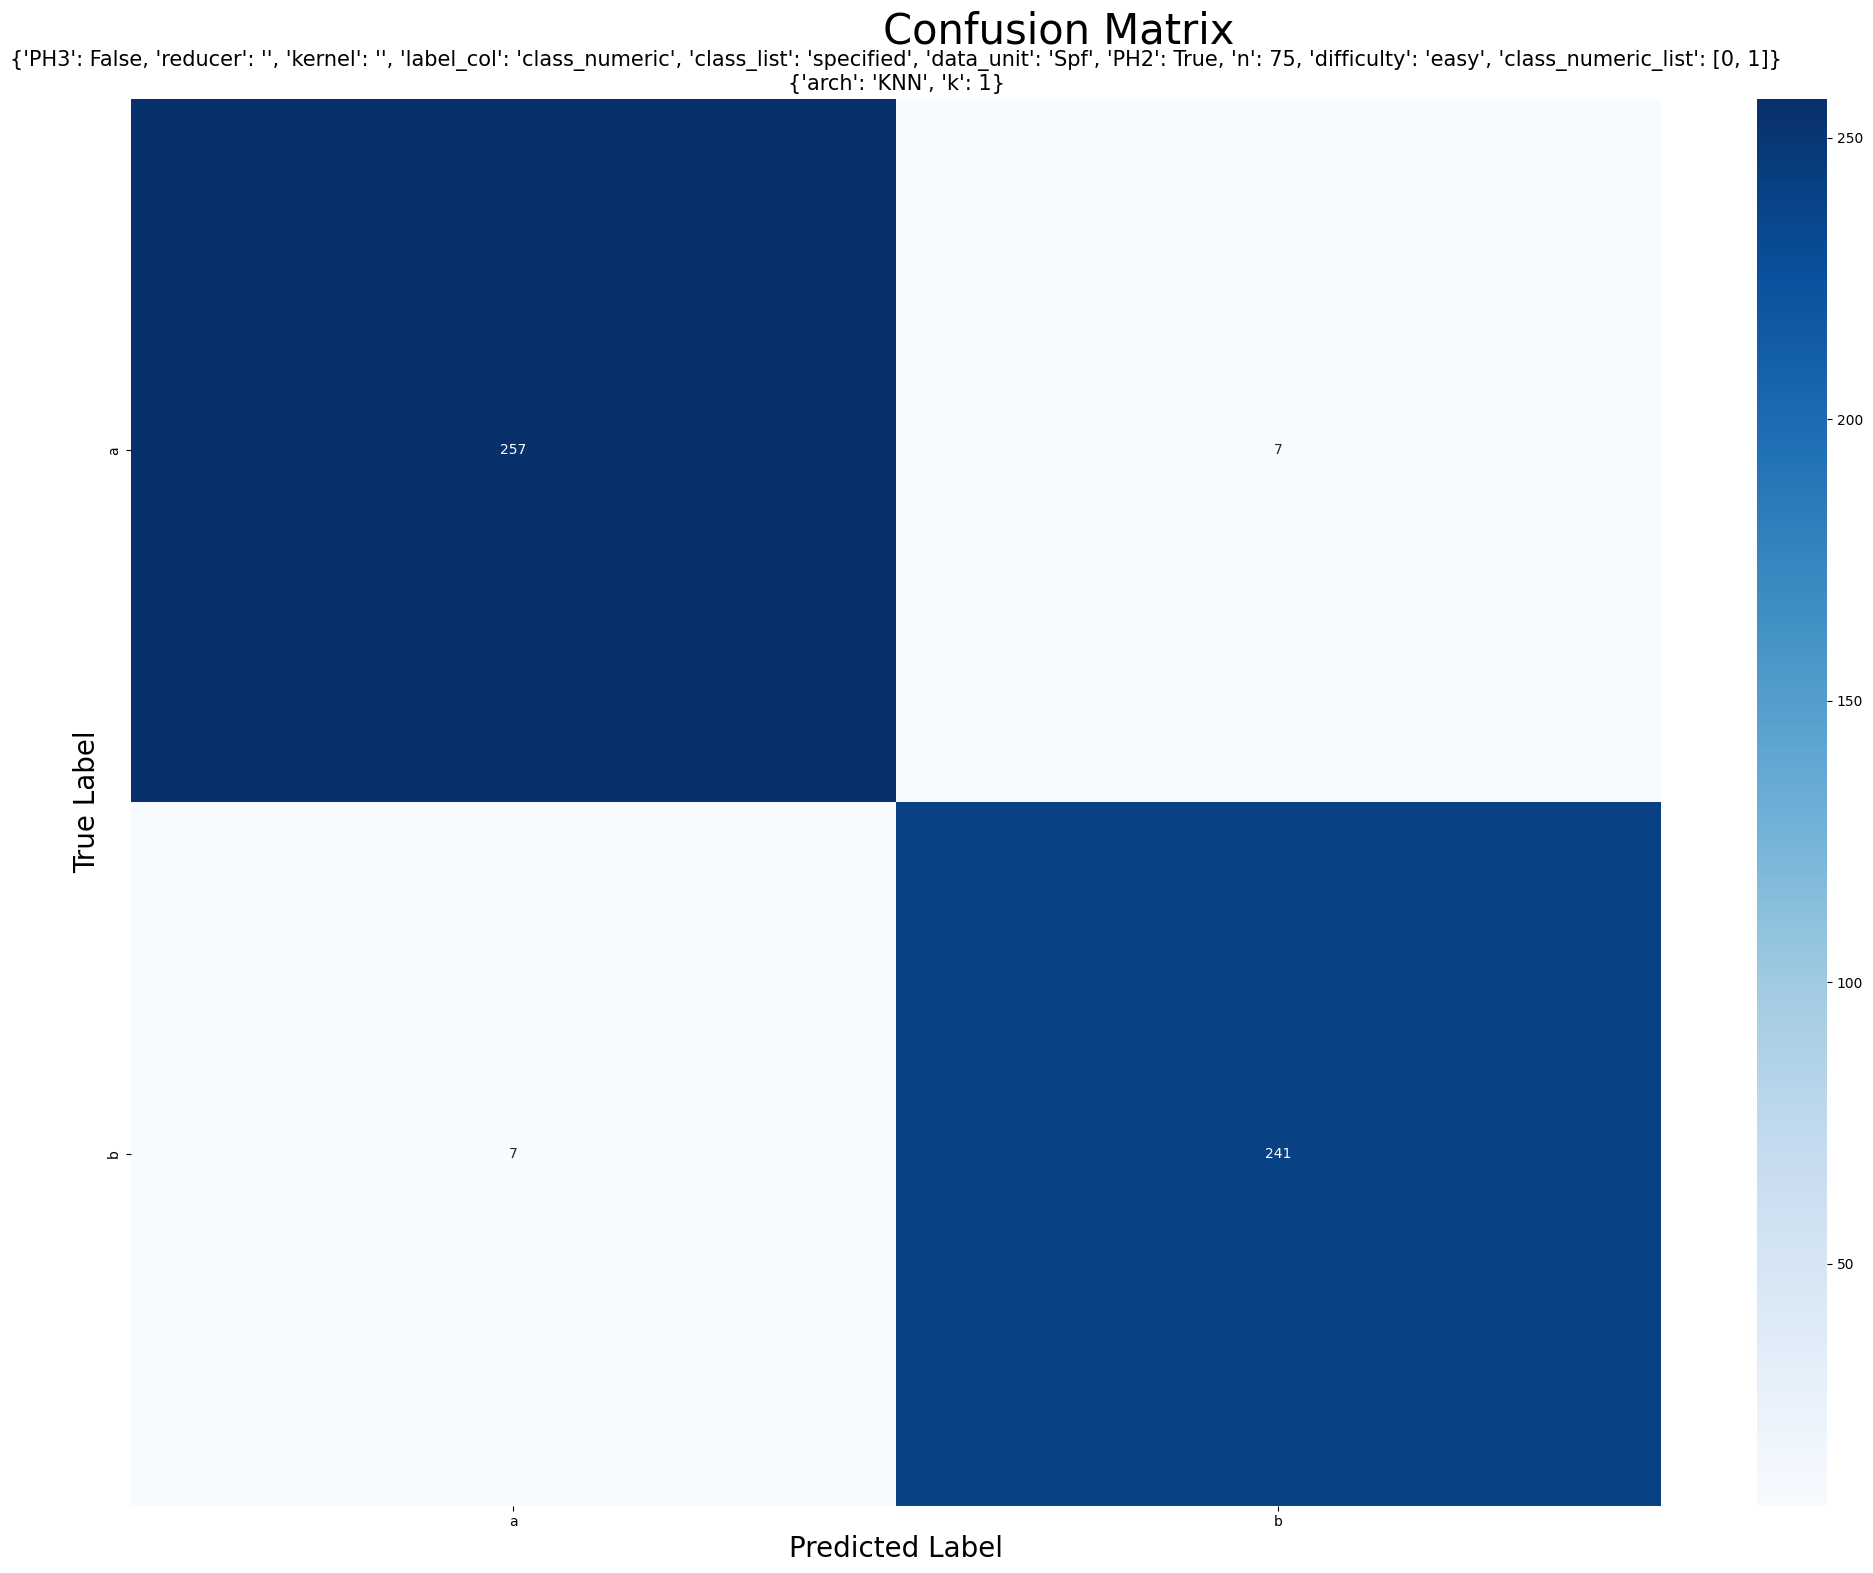

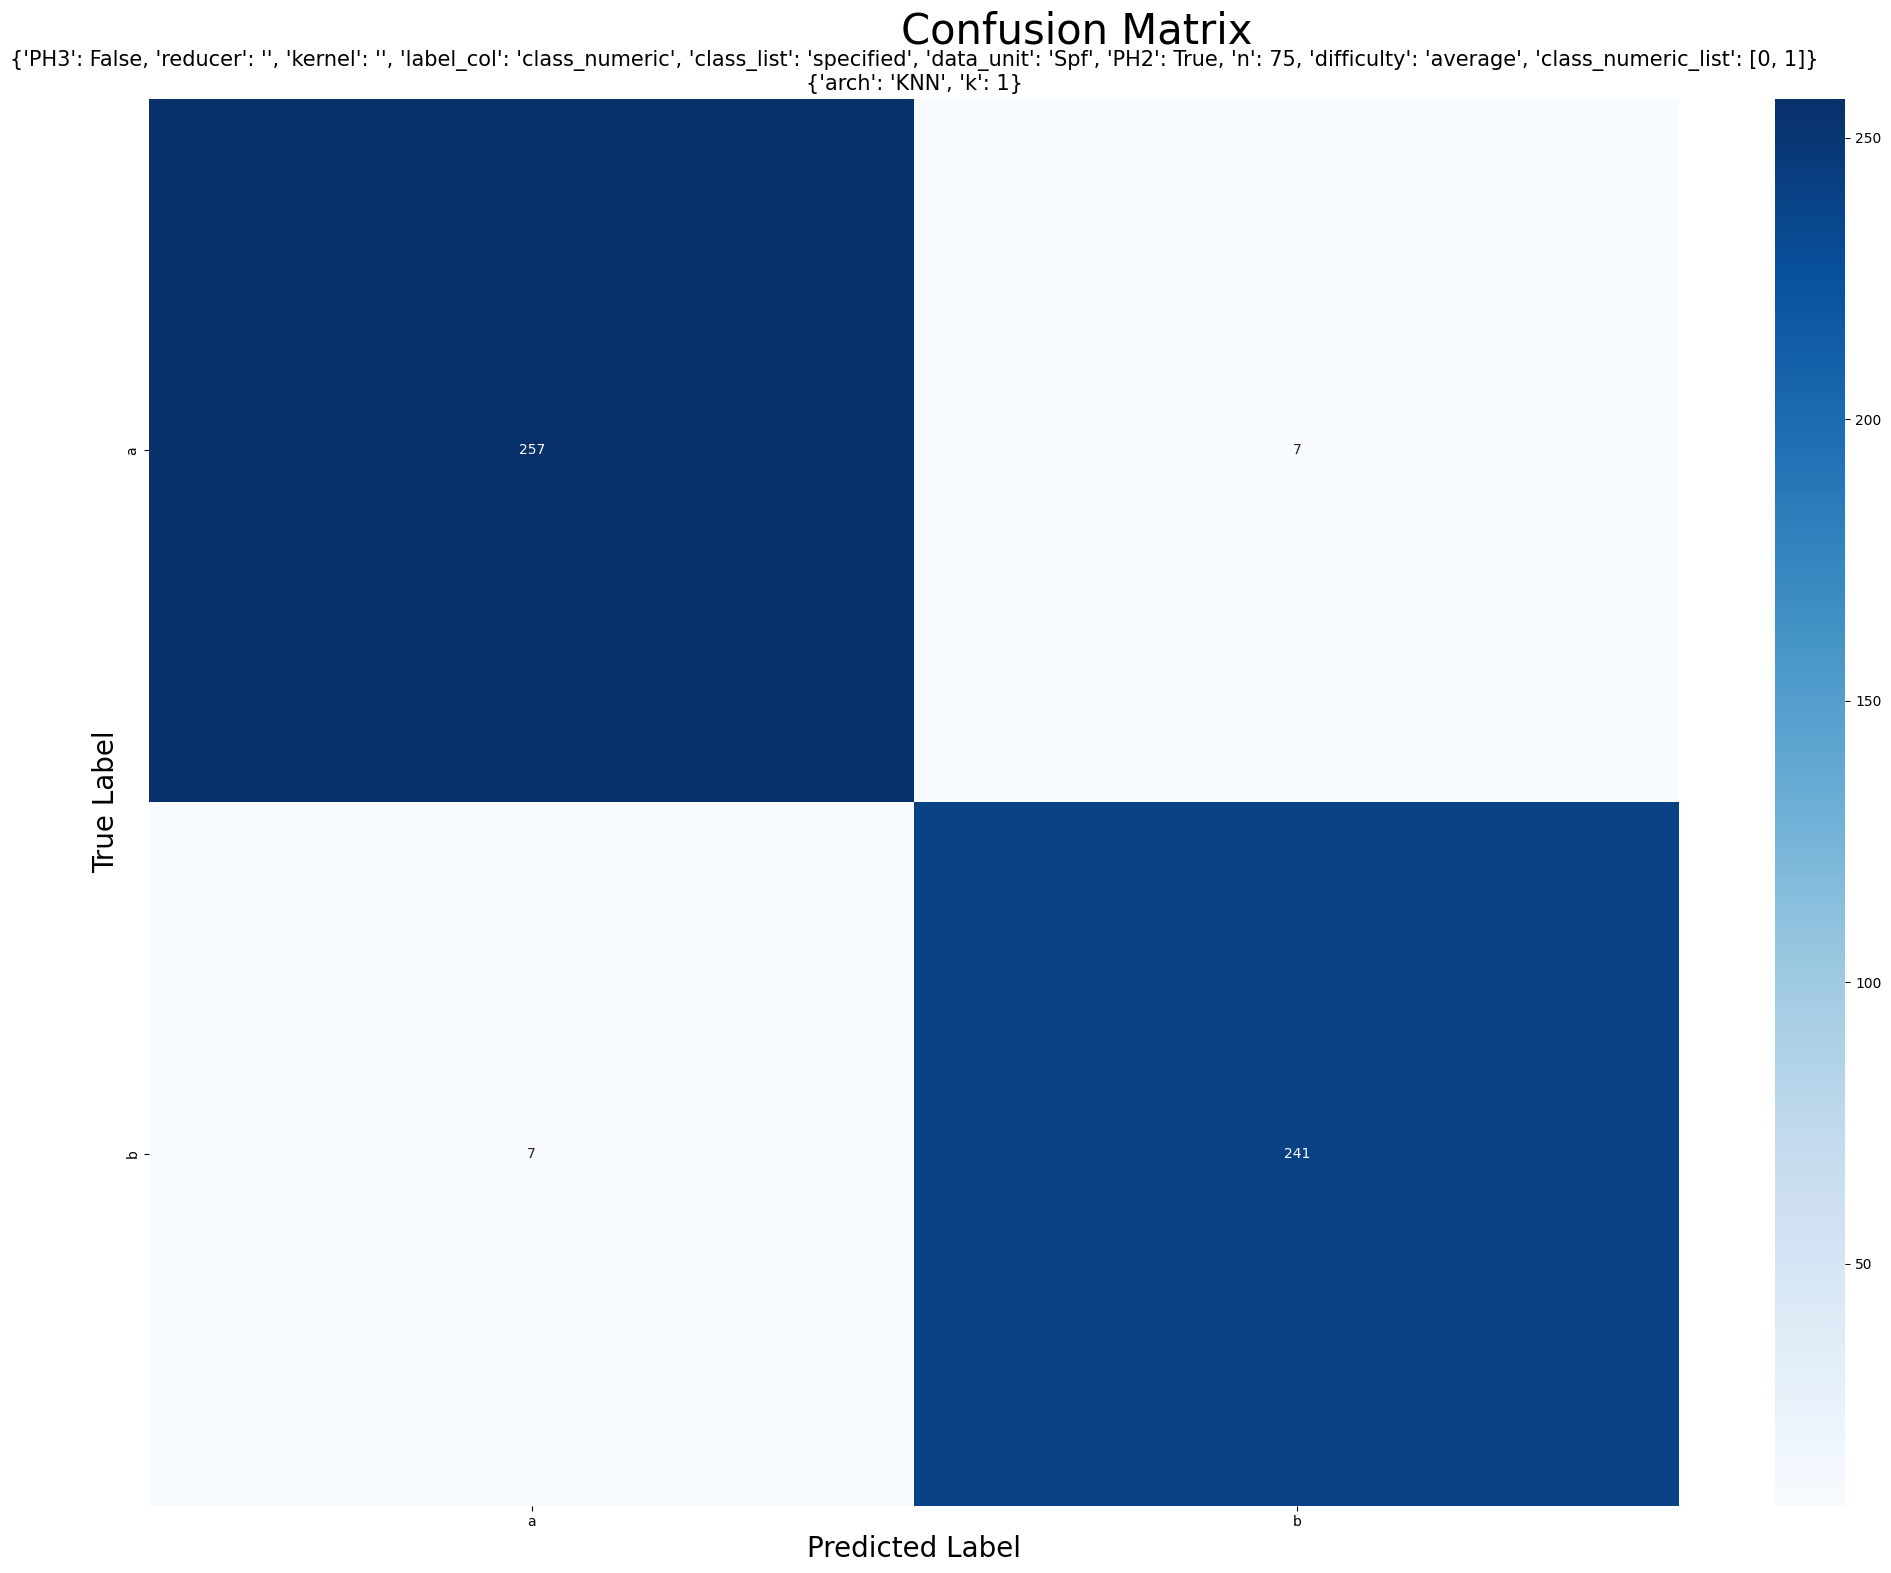

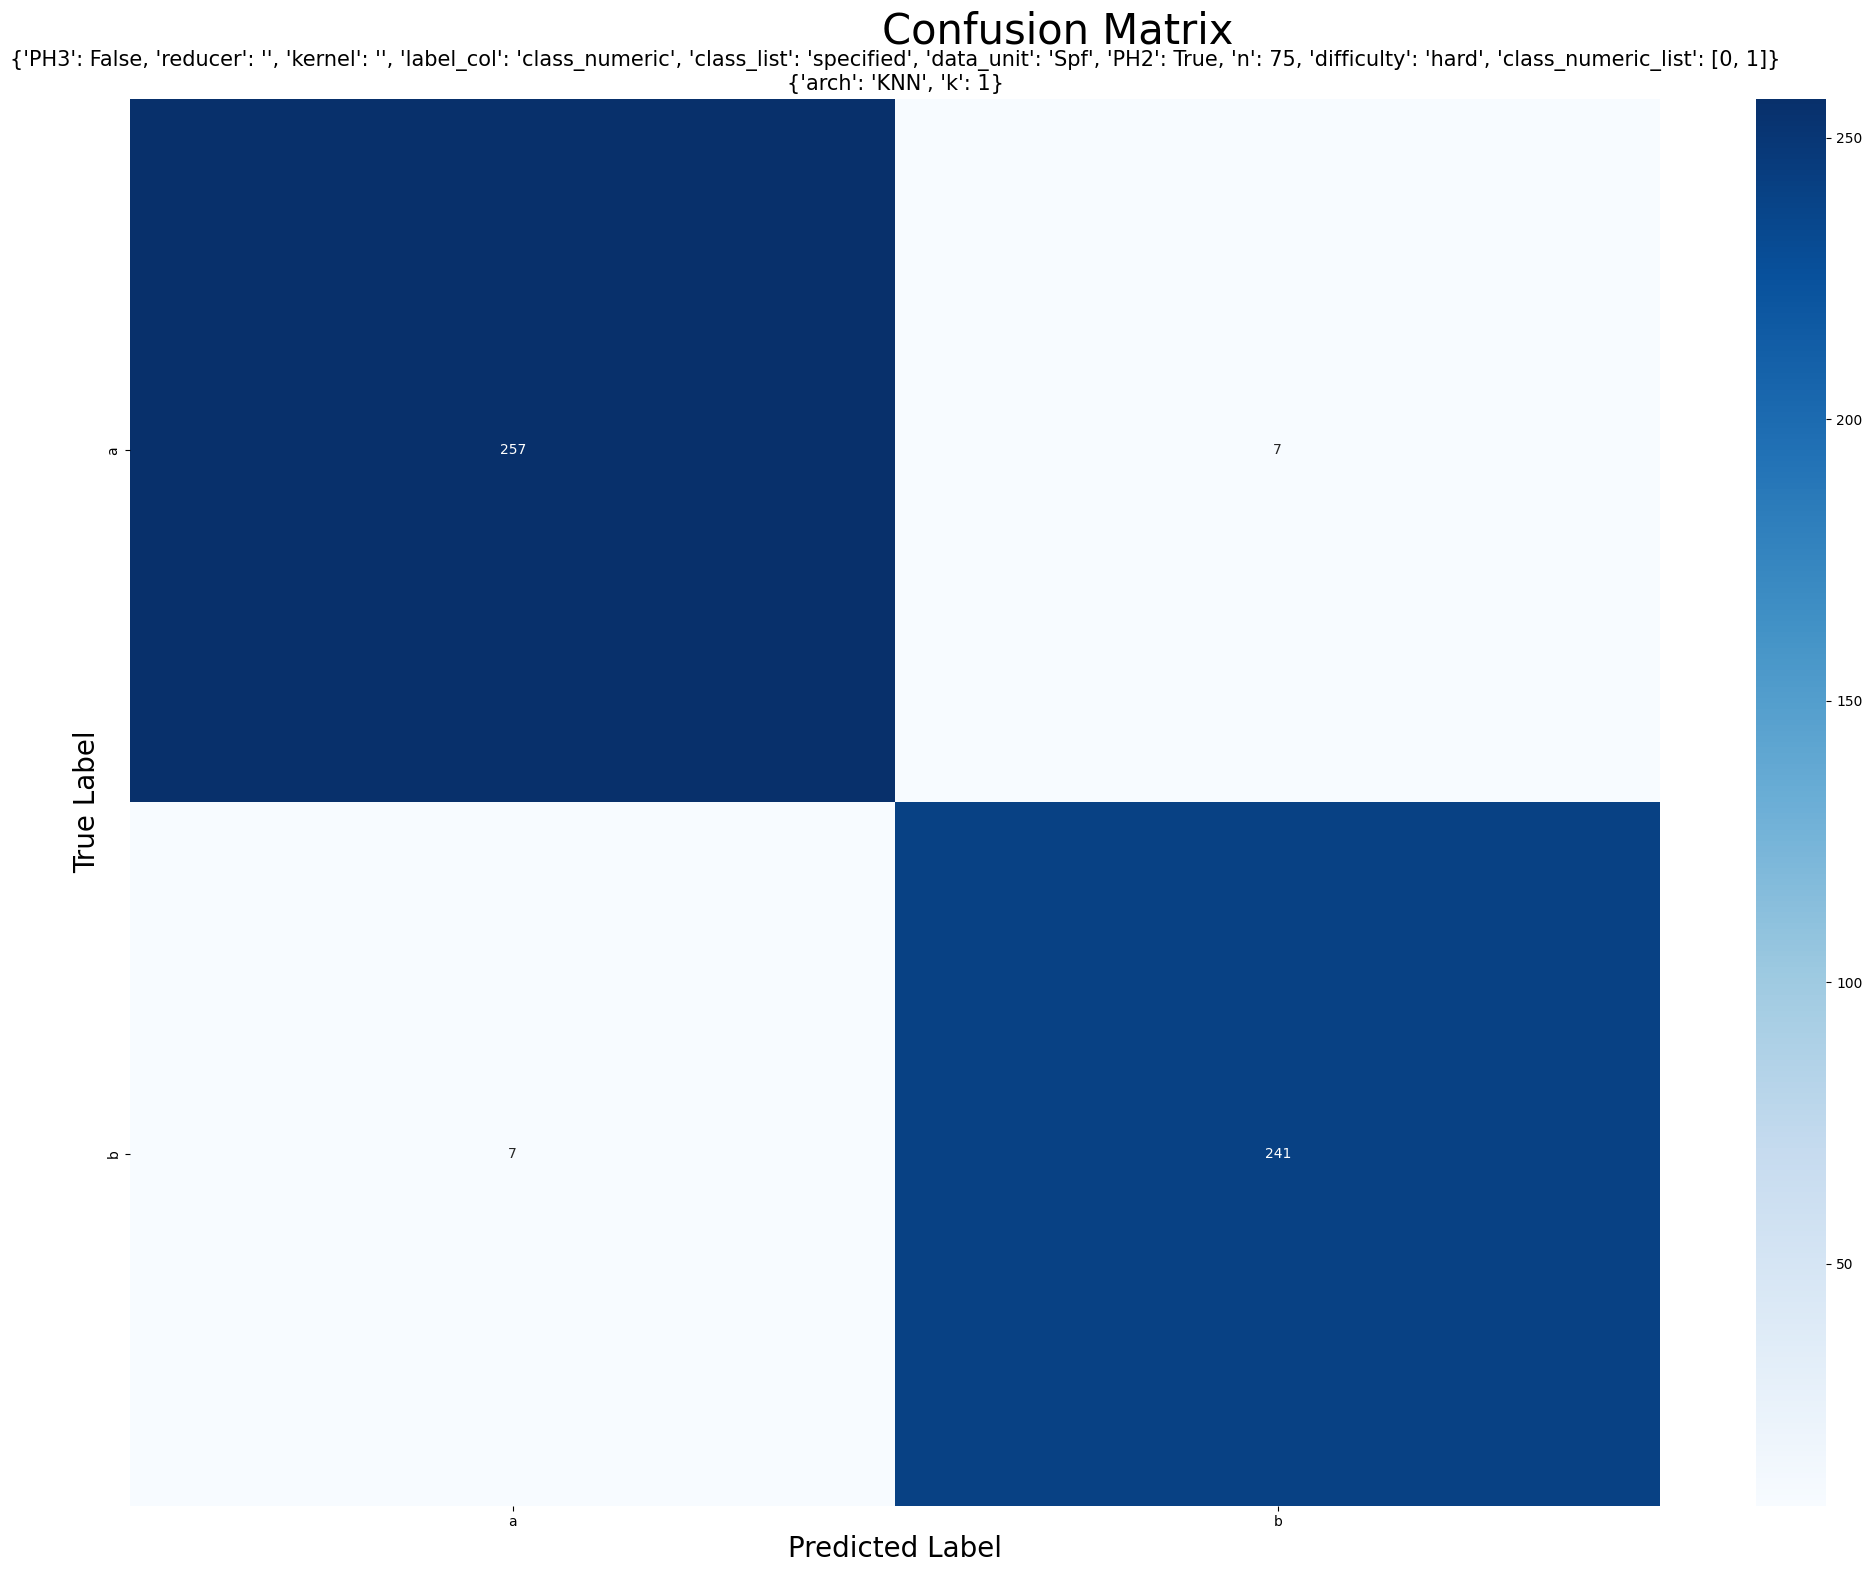

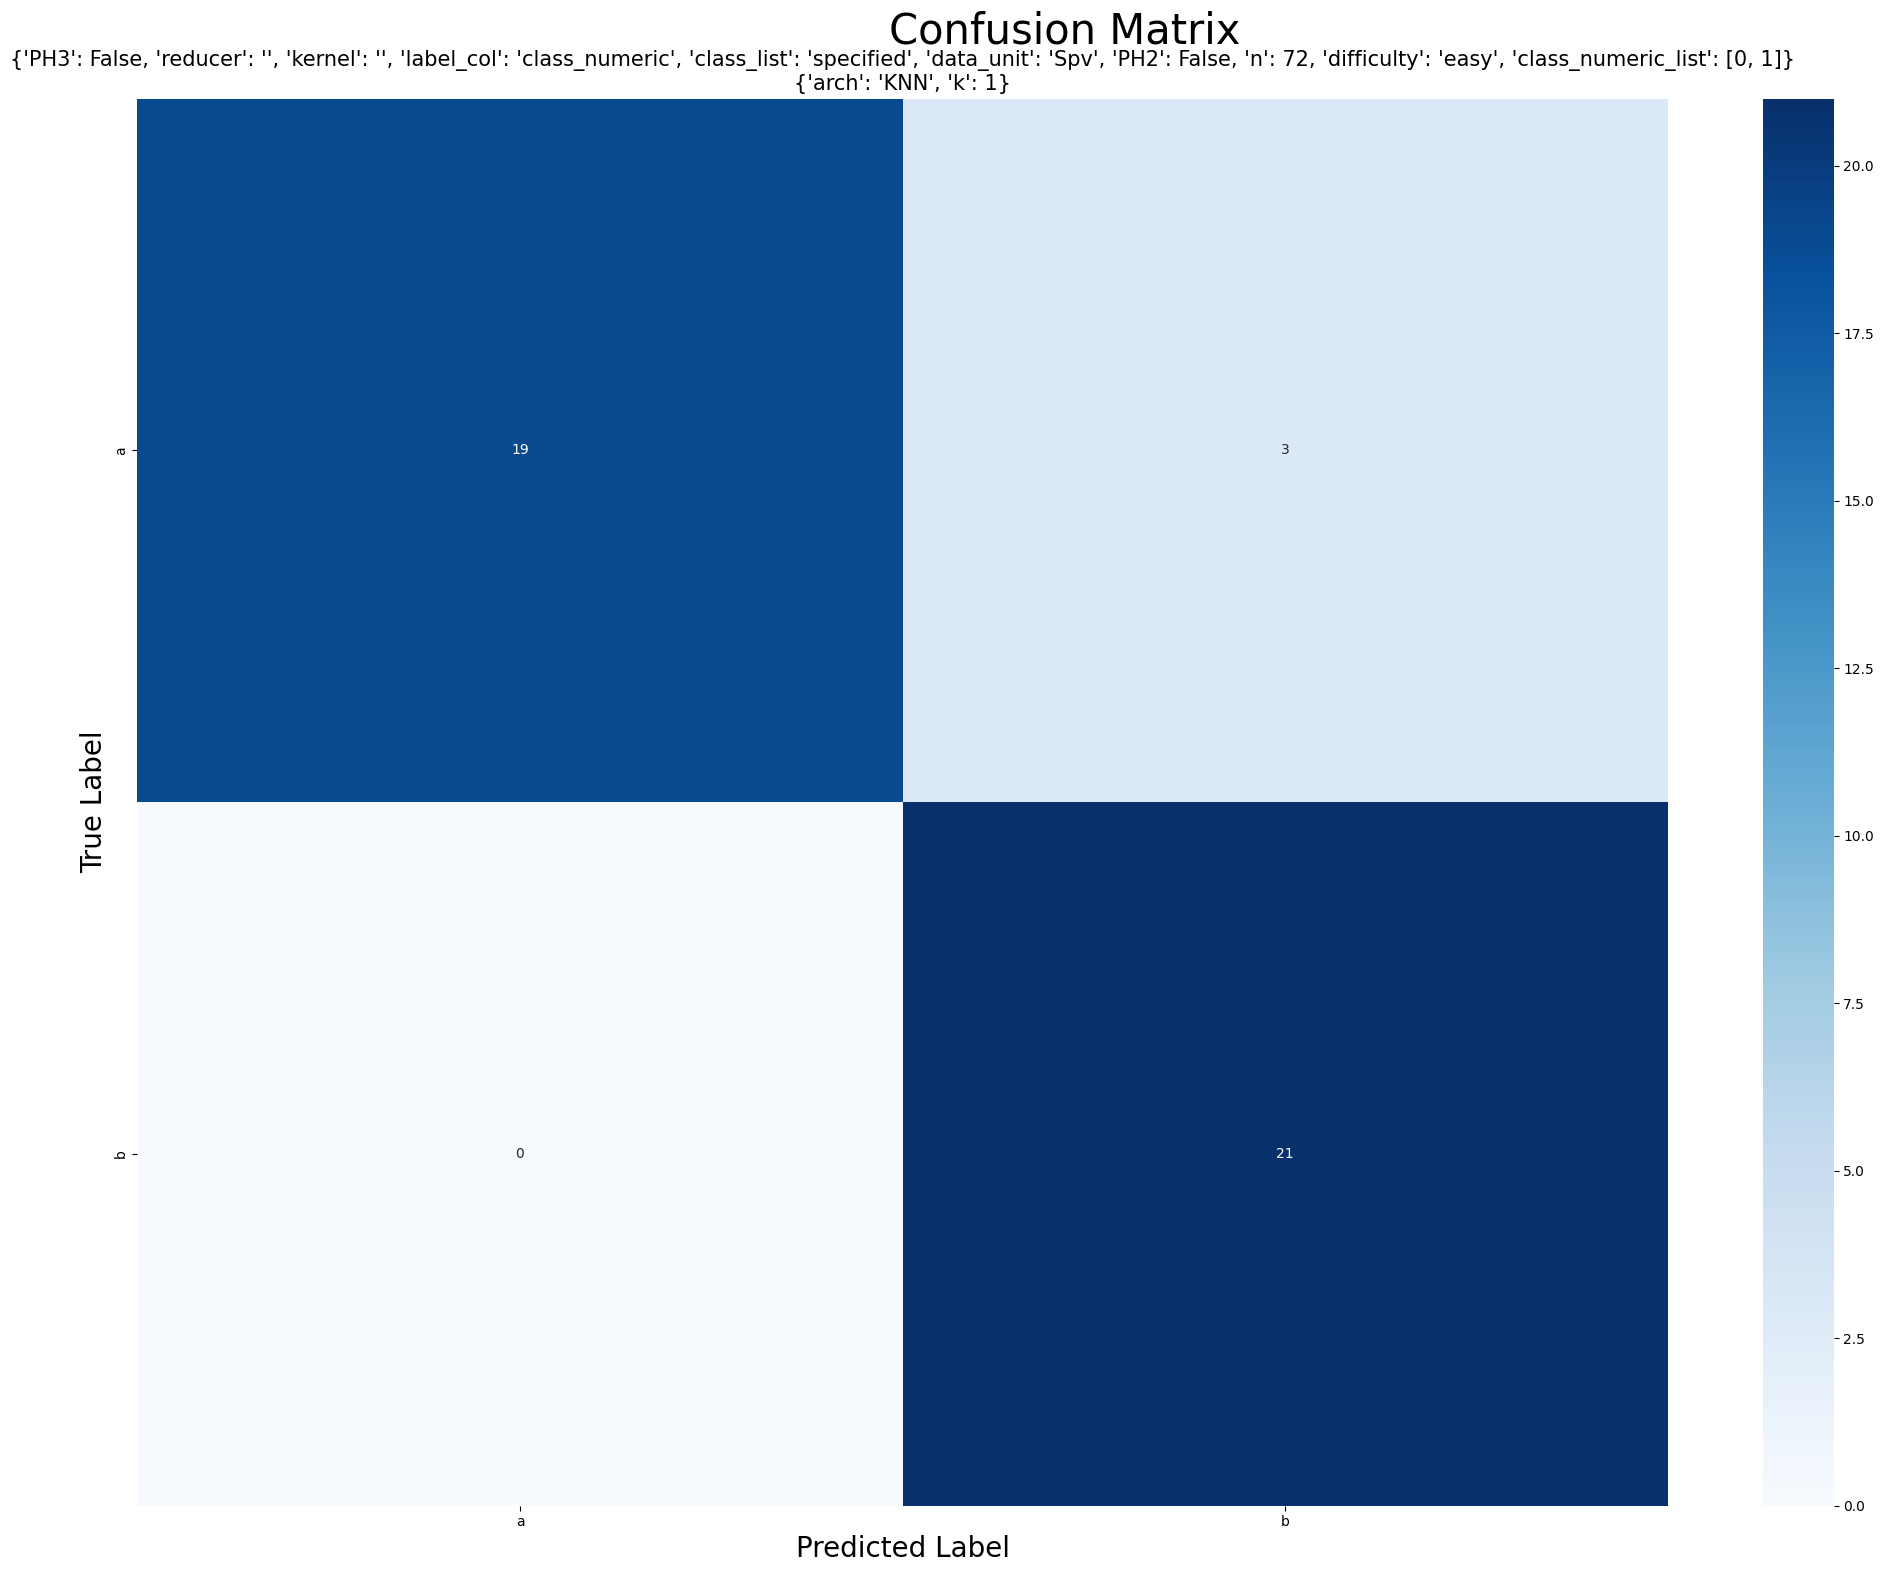

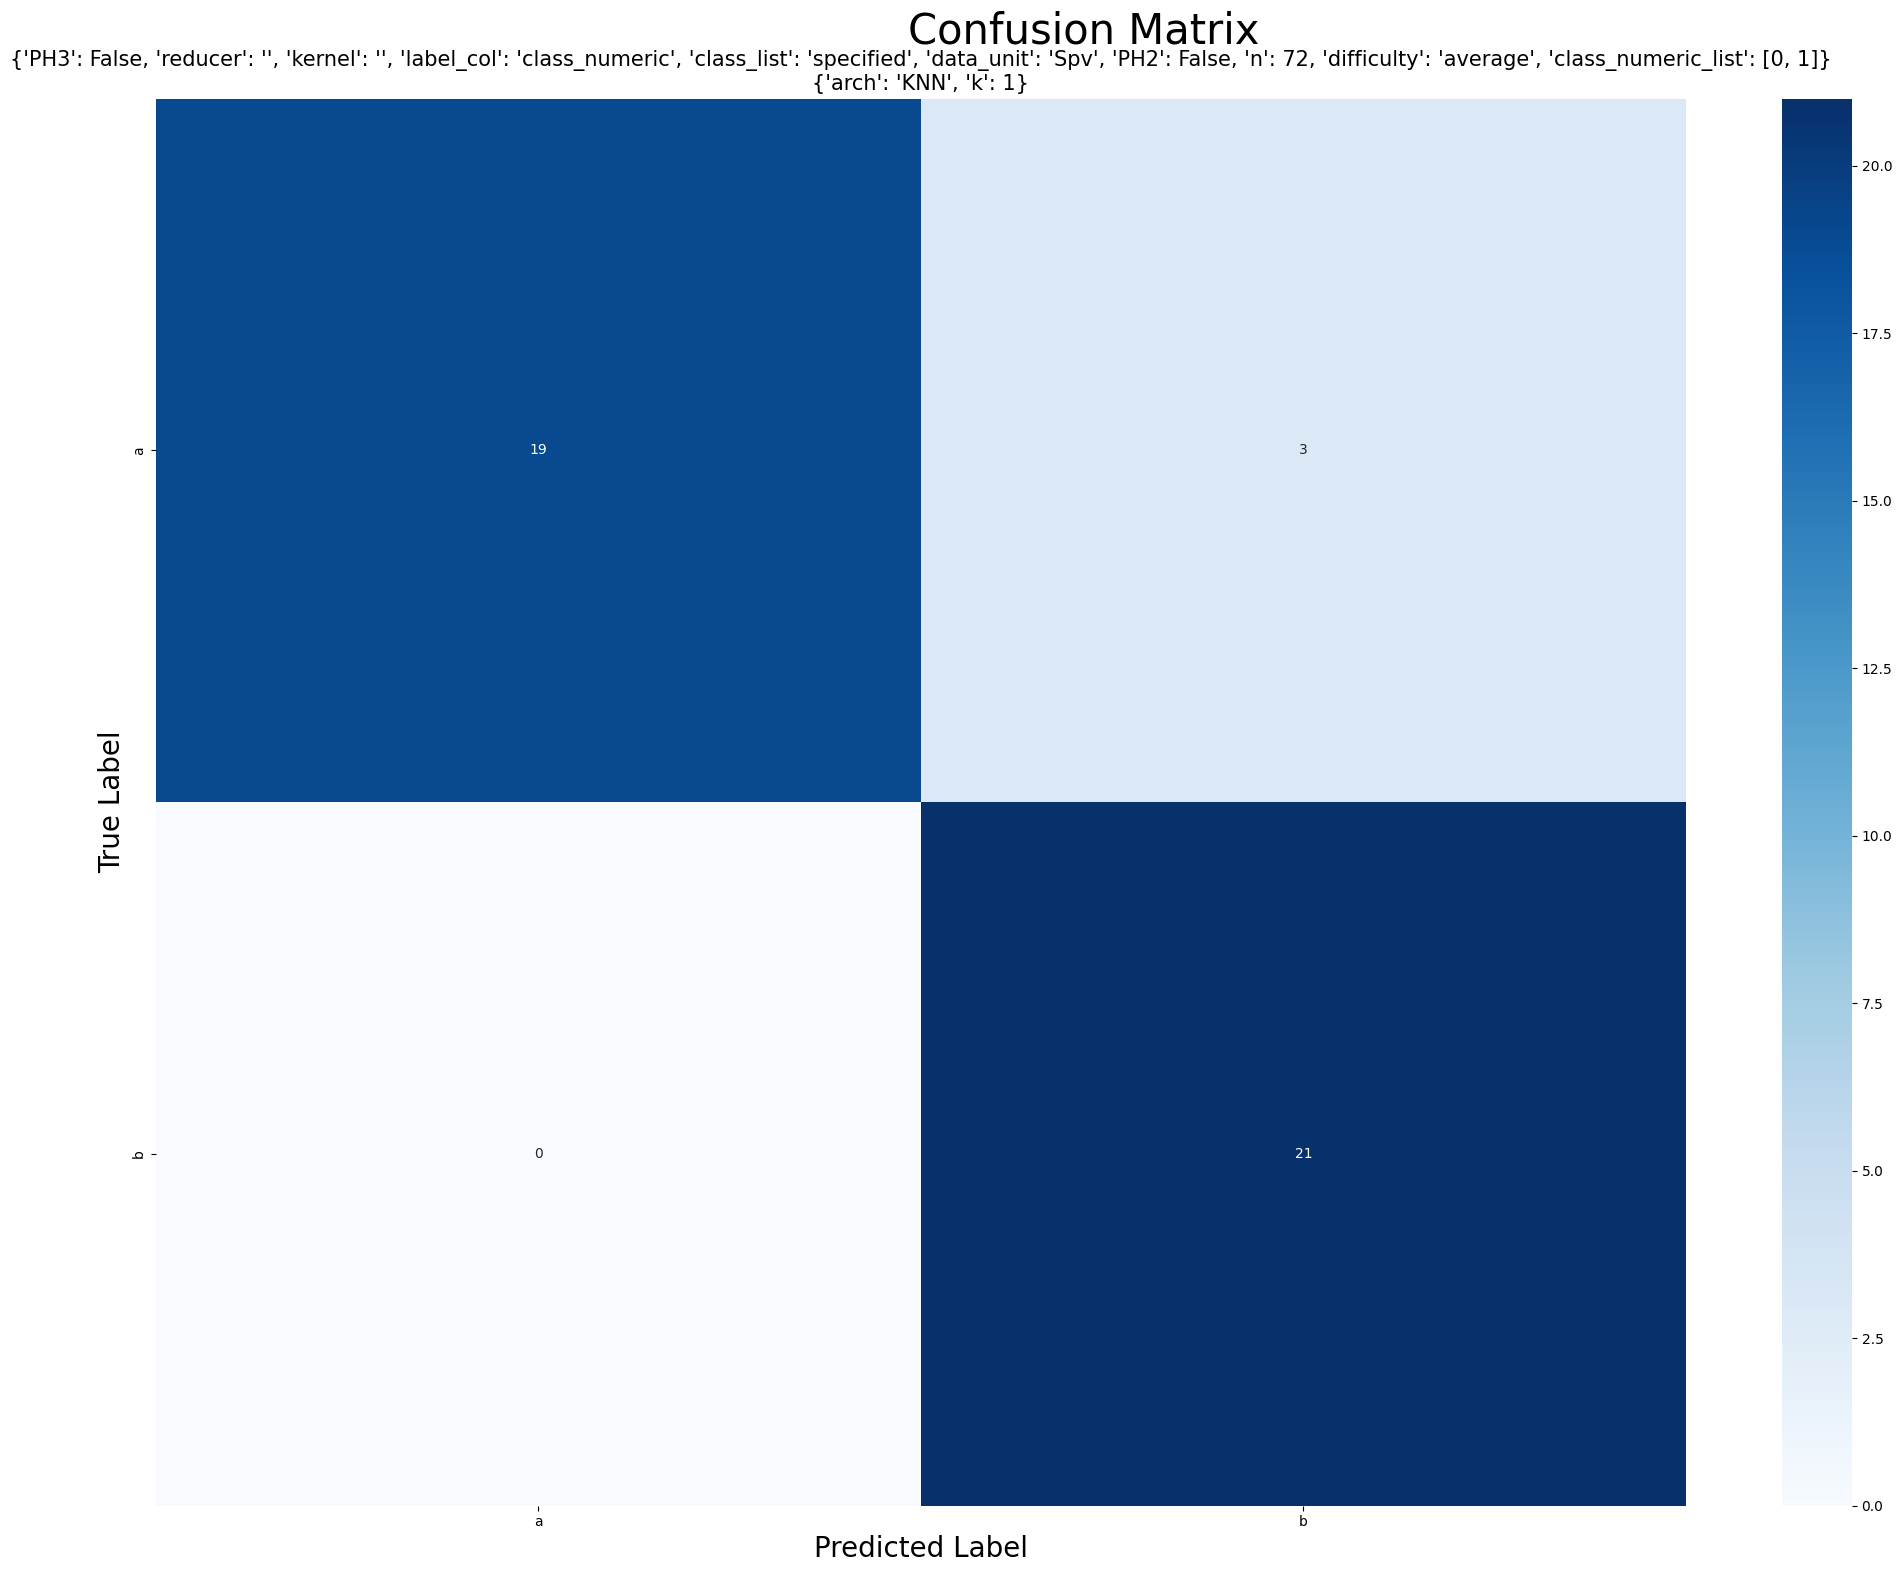

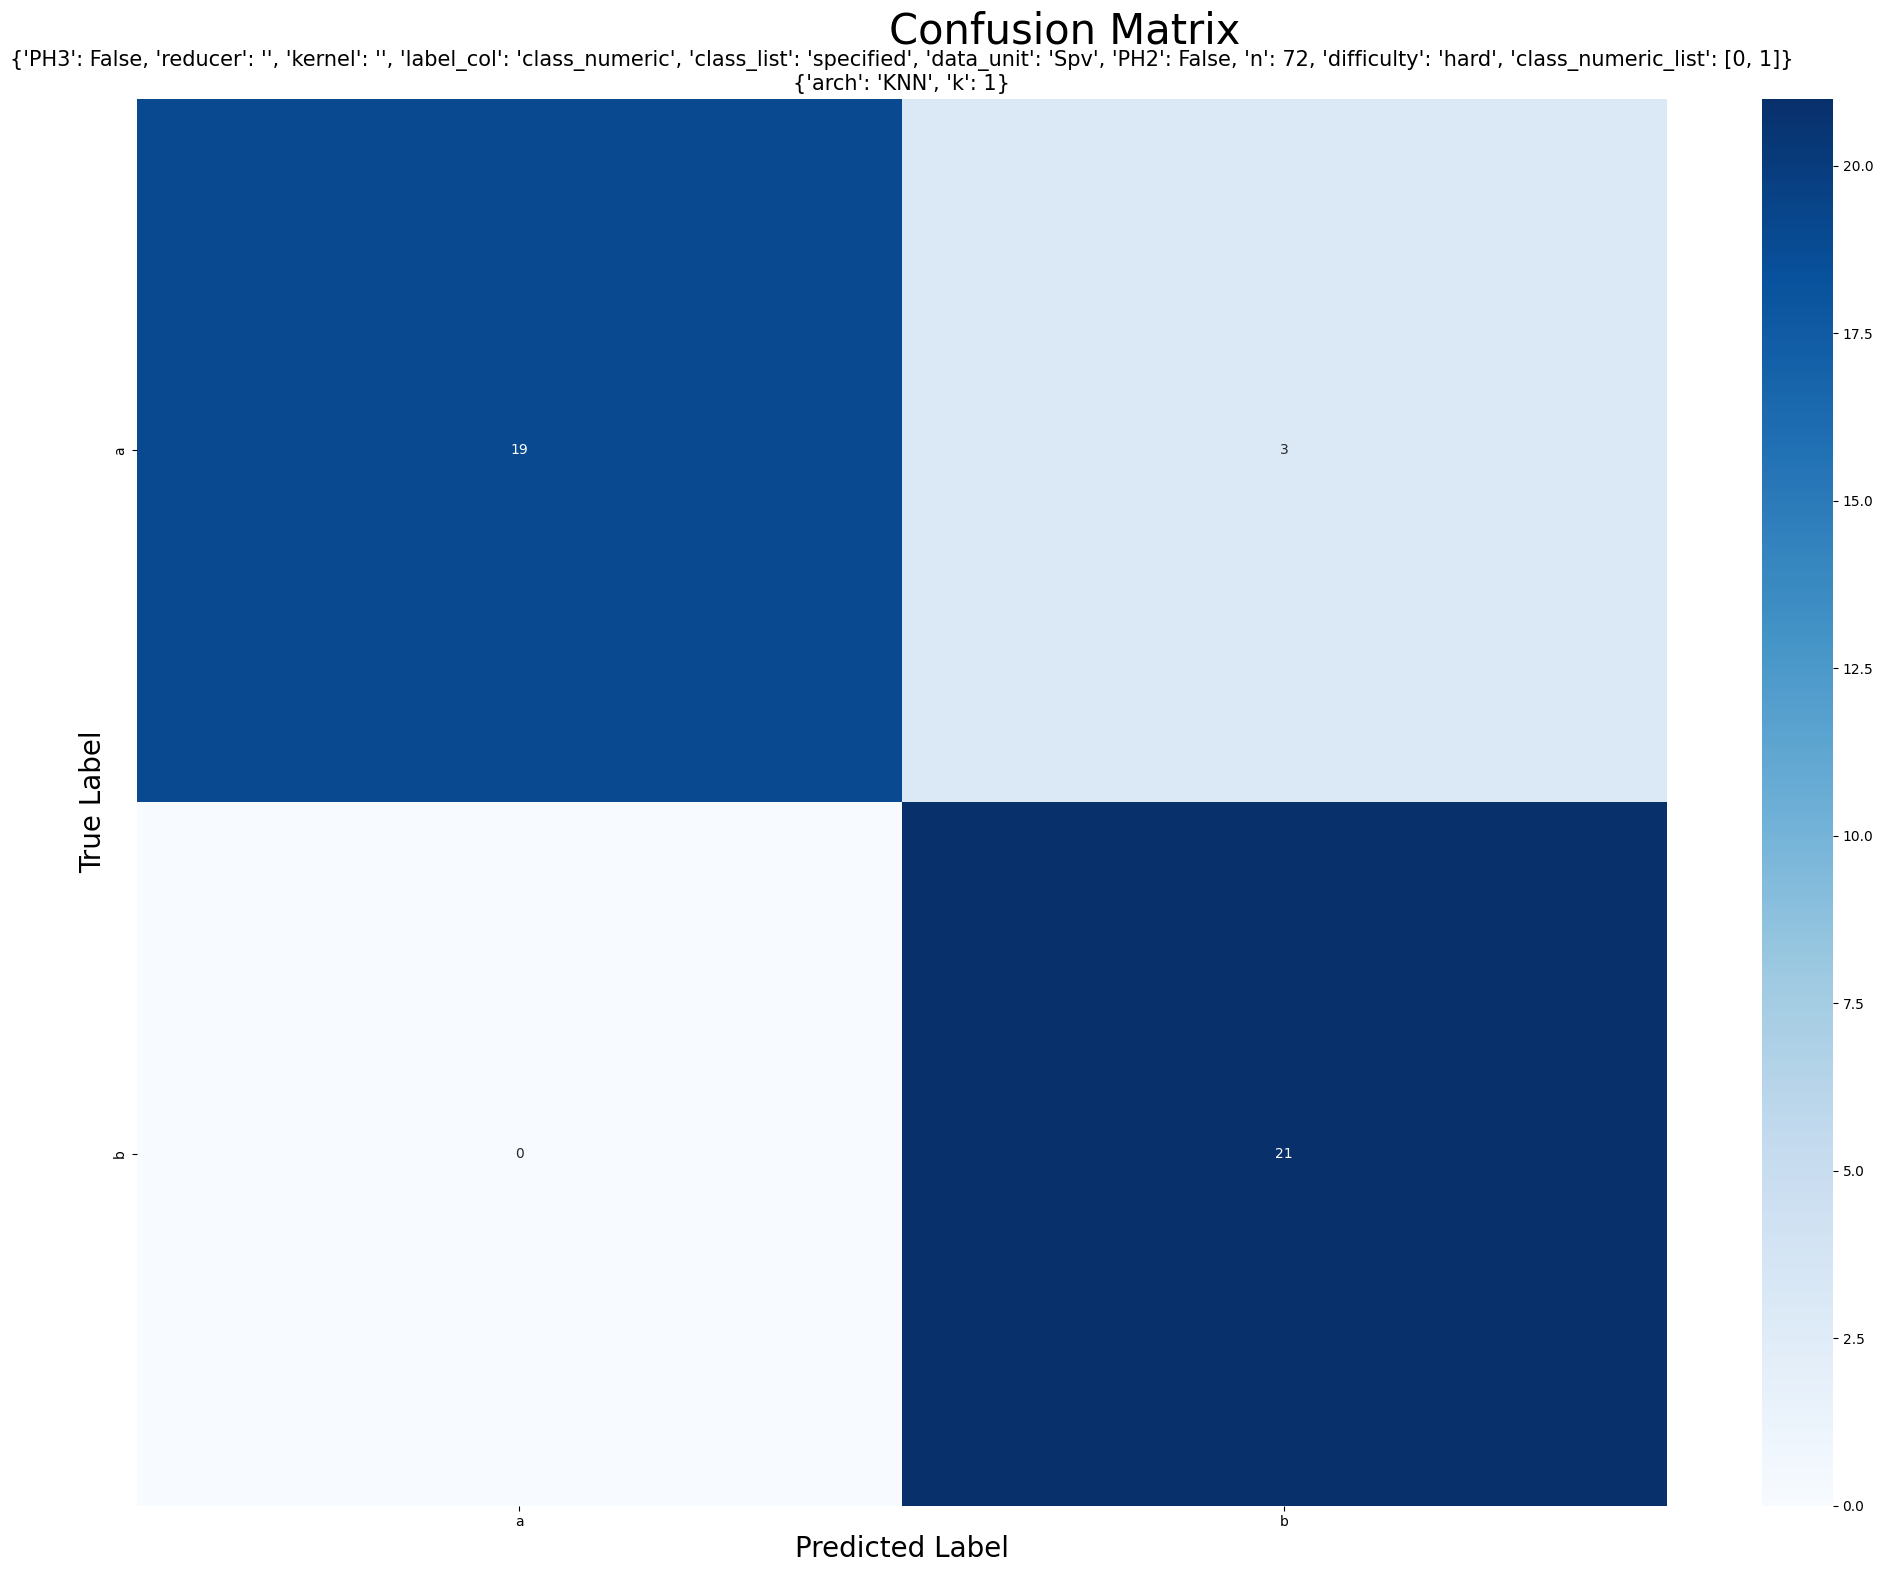

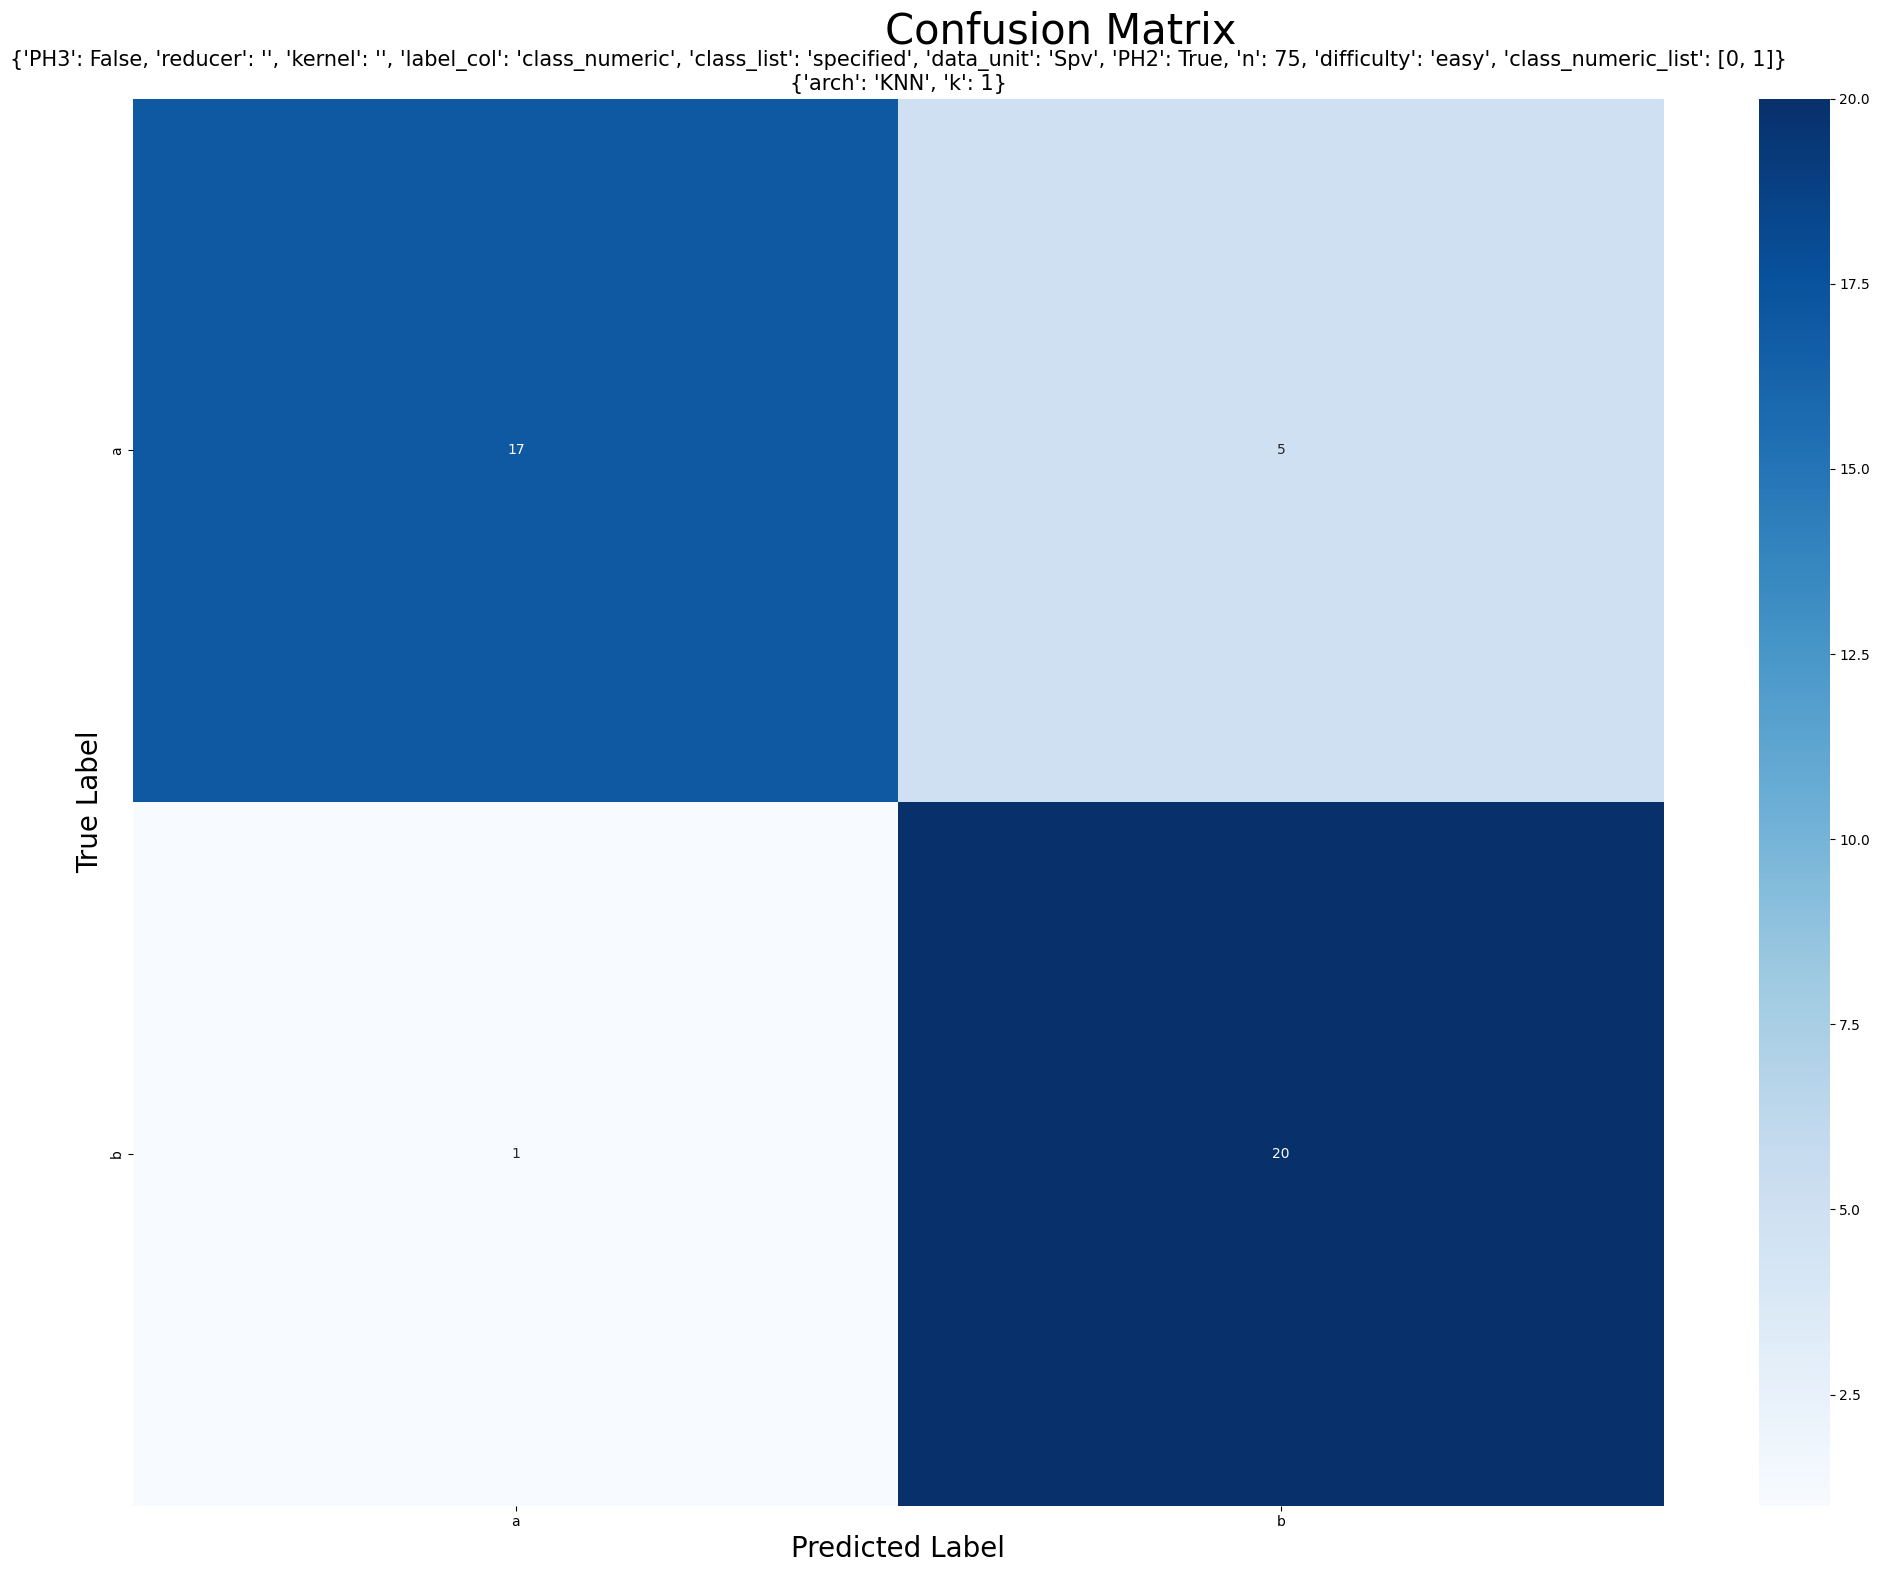

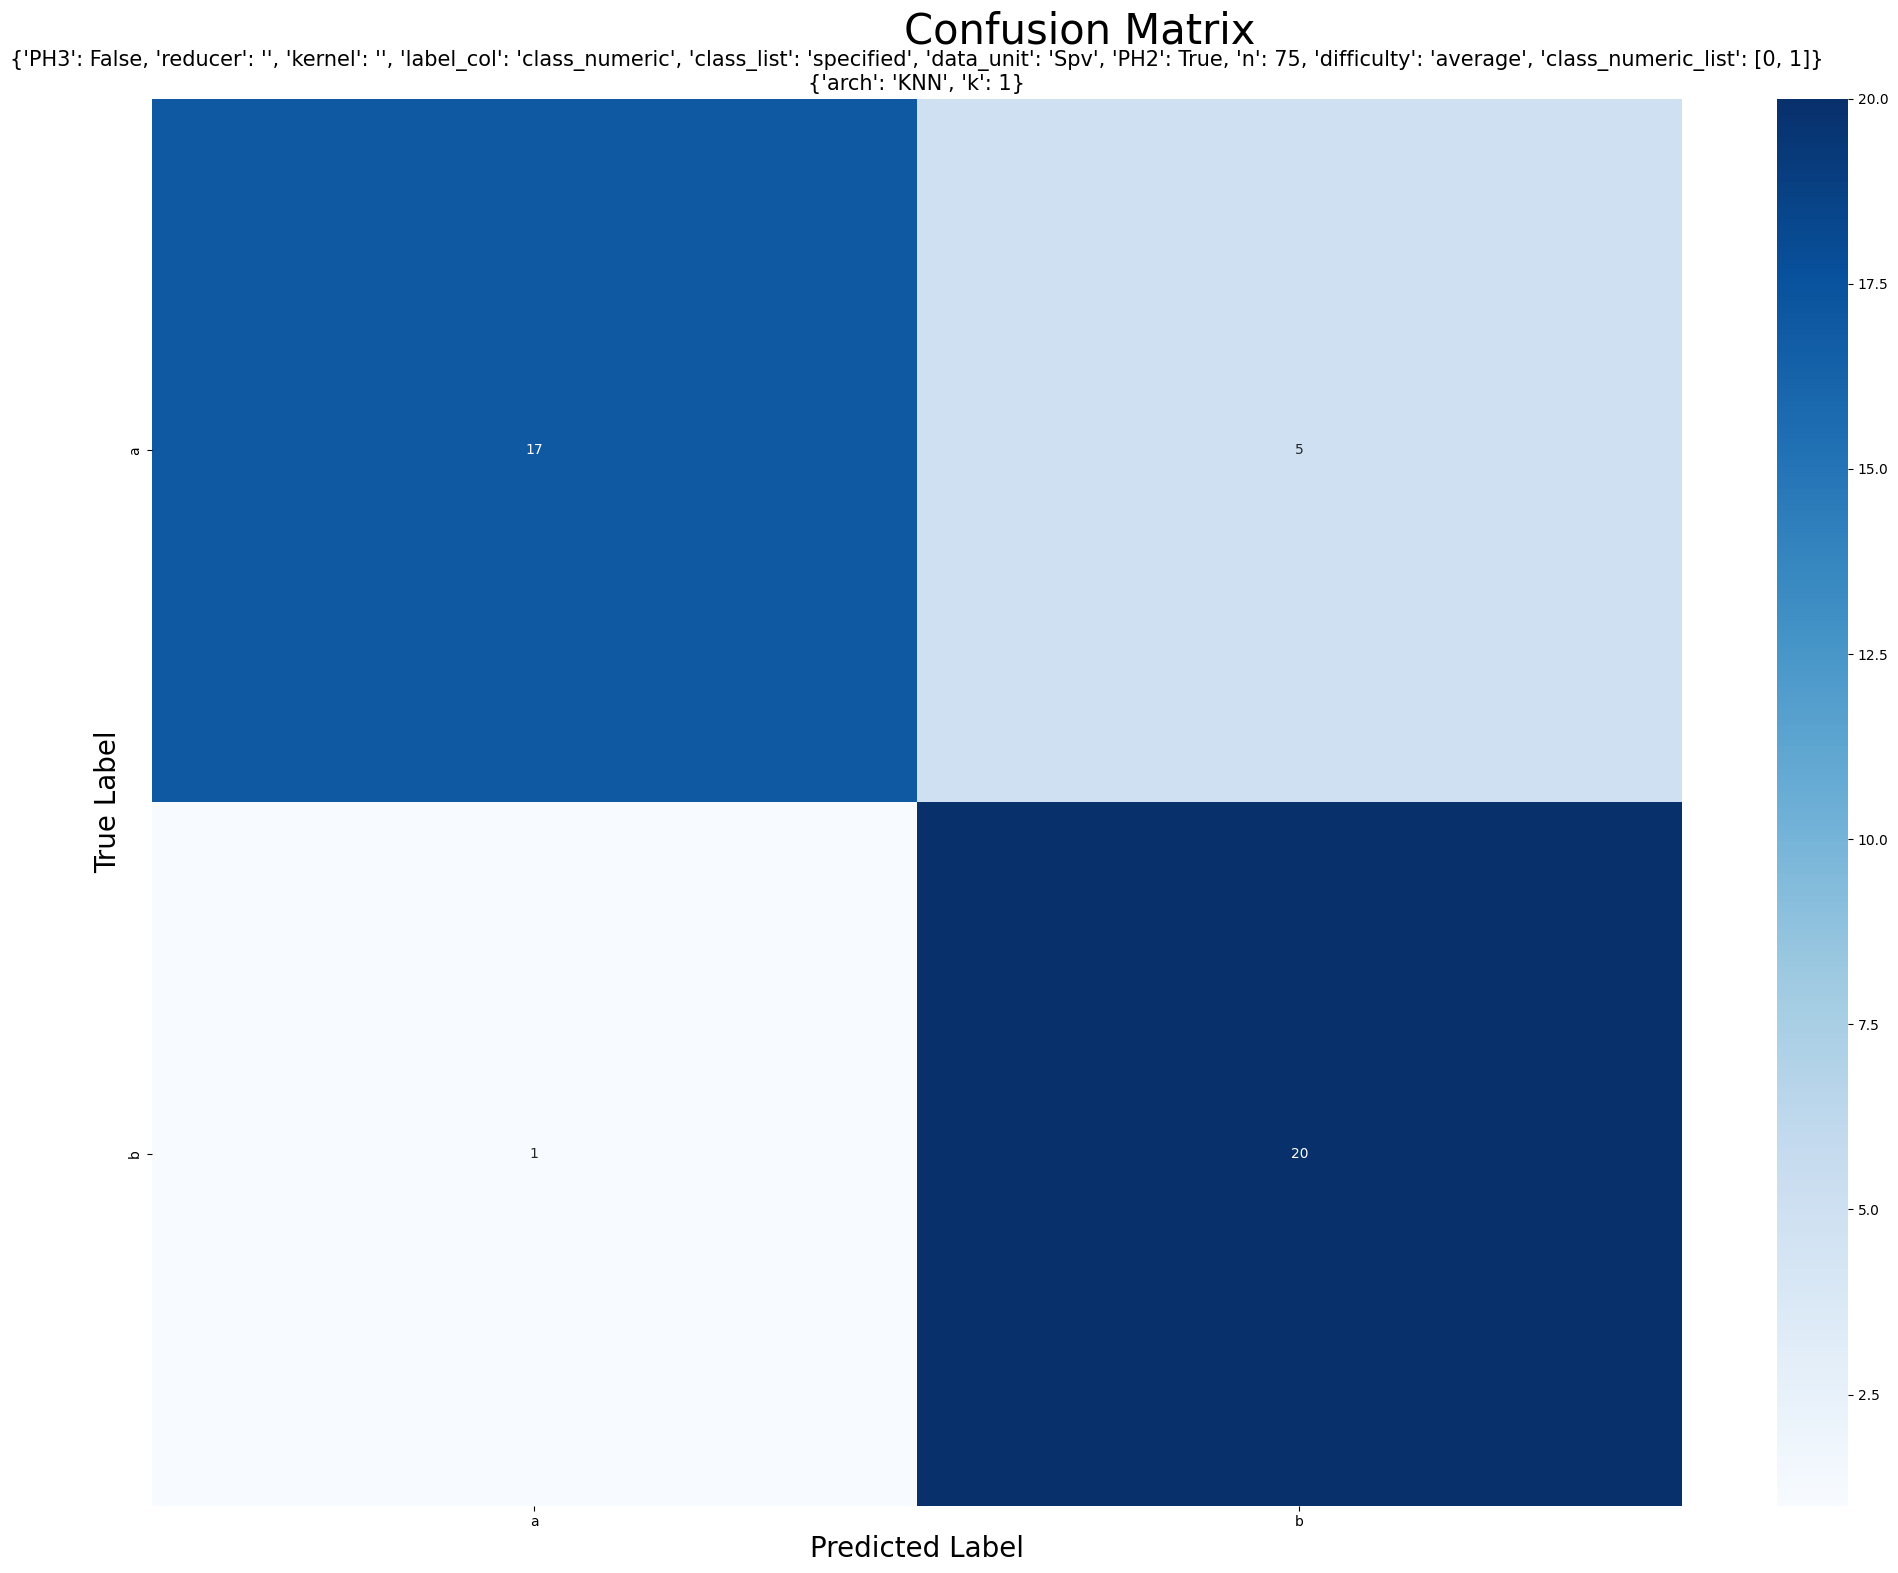

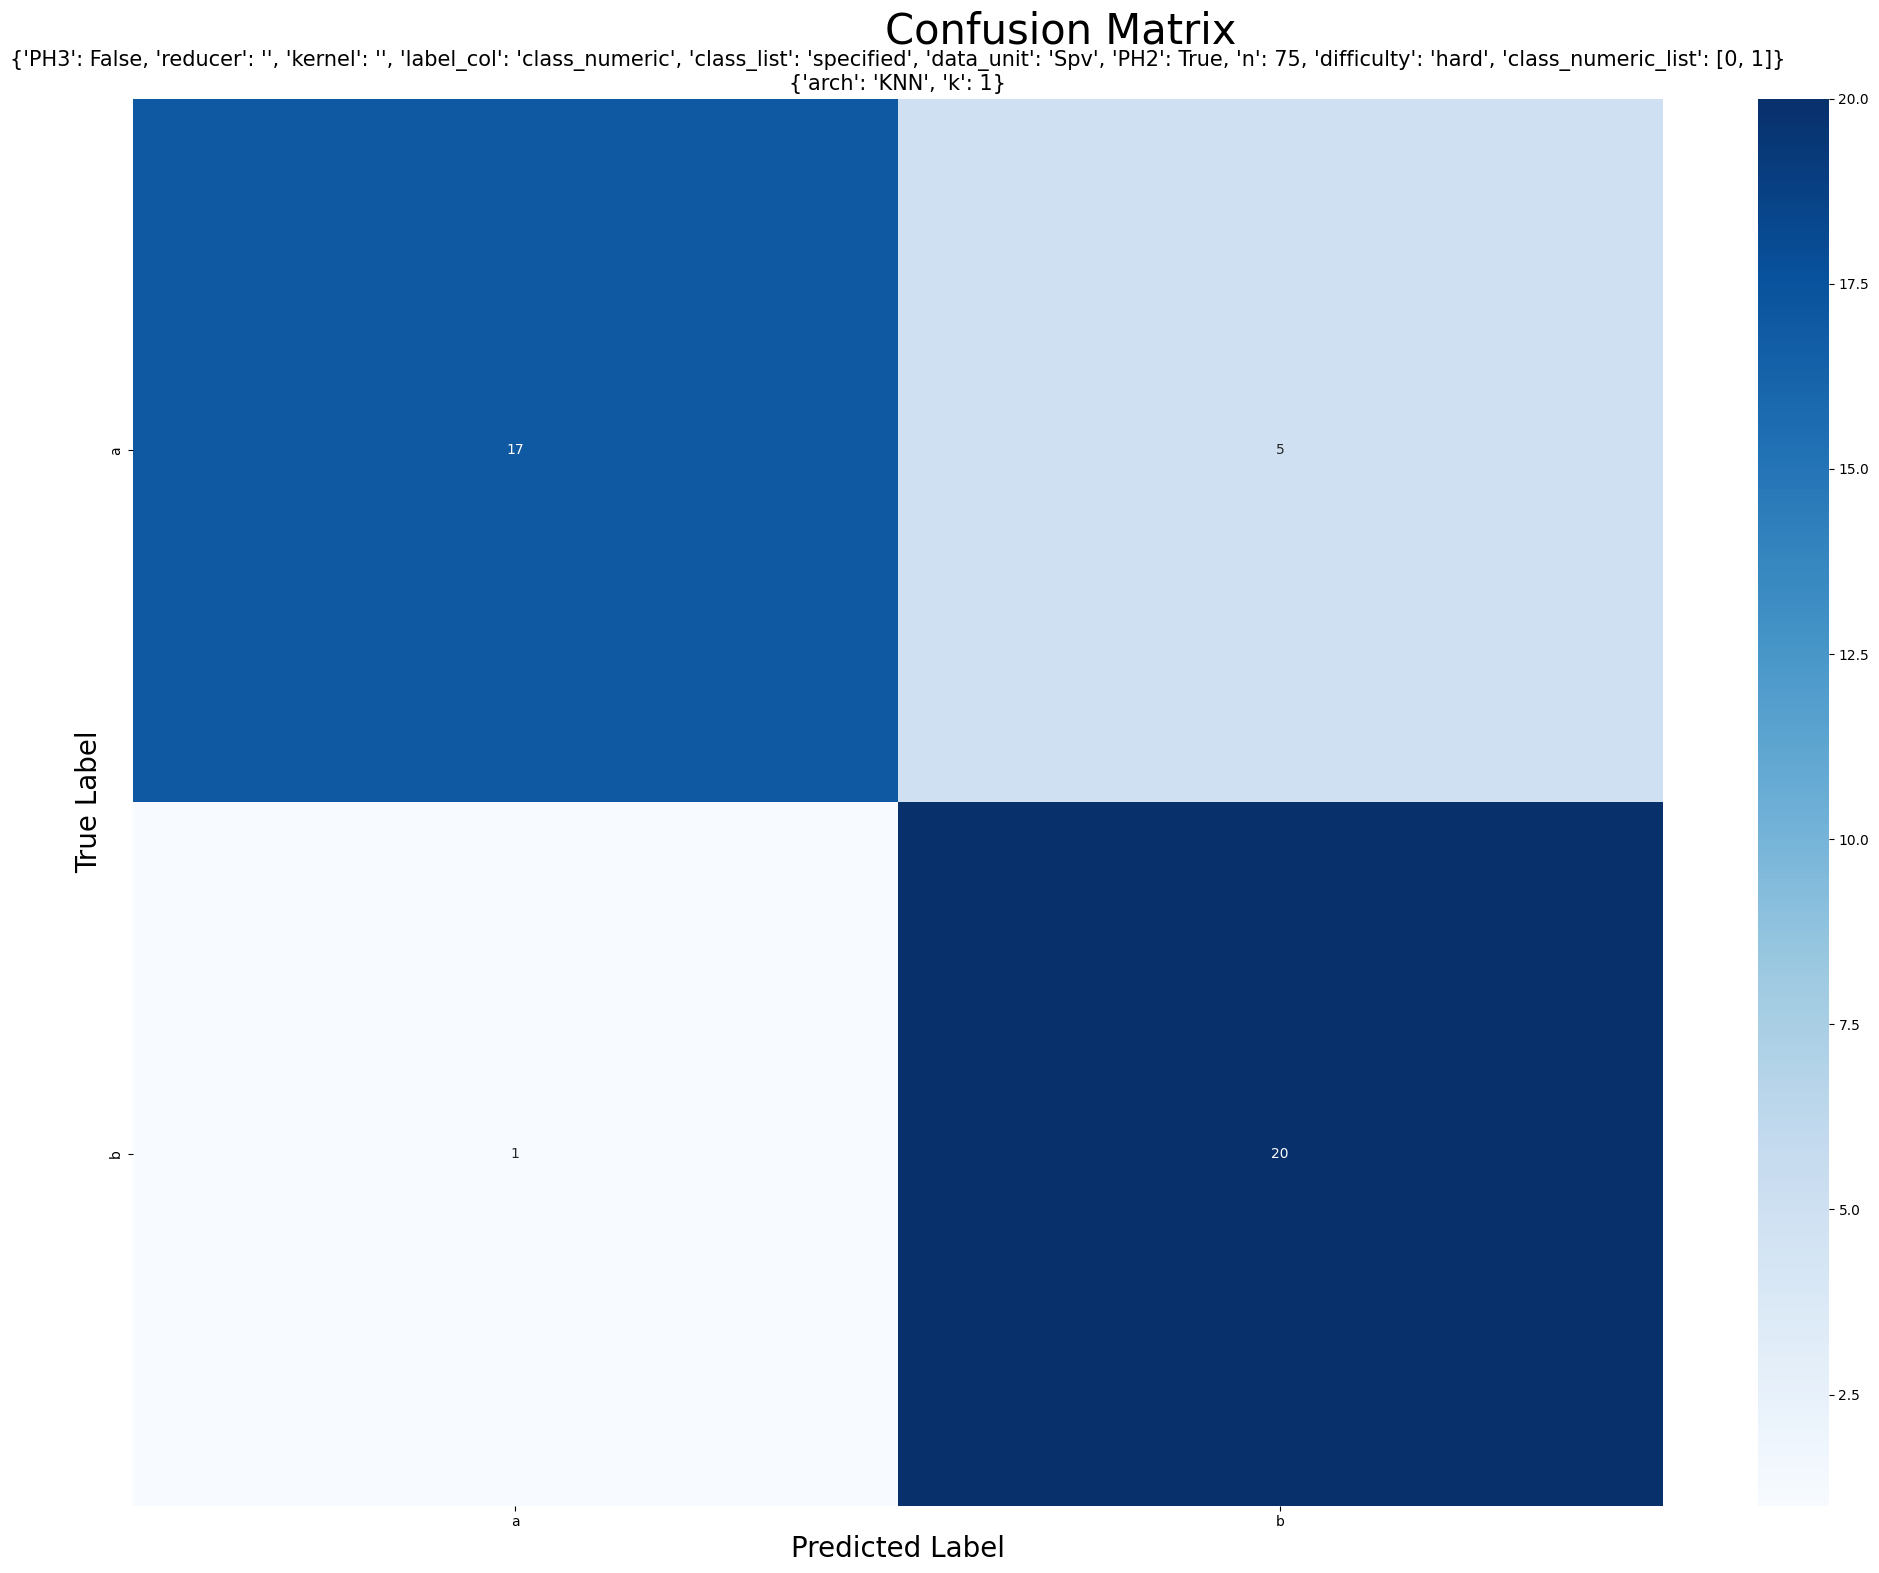

In [8]:
for data_unit in [sup.DATA_S_PF, sup.DATA_S_PV]:
  data_config = base_data_config.copy()
  train_config = base_train_config.copy()

  data_config["data_unit"] = data_unit

  for PH2 in [False, True]:
    data_config["PH2"] = PH2
    data_config["n"] = 75 if PH2 else 72

    for n in num_class_candidates:
      s = subsets[n]
      for difficulty in ['easy', 'average', 'hard']:
        s_dif = s[difficulty]
        data_config["difficulty"] = difficulty
        data_config["class_numeric_list"] = s_dif
        
        print(data_config)
        print(train_config)
        model = knn.KNN(data_config=data_config, df=None, 
                          train_config=train_config)
        
        model.fit()

        model.test()

        model.full_score()
        print(model.accuracy)
        print(model.top2accuracy)
        print(model.macro_f1)
        print(model.macro_precision)
        print(model.macro_recall)

        metrics = {"data_unit" : data_unit,
                    "PH2" : PH2,
                    "num_classes" : n,
                    "difficulty" : difficulty,
                    "accuracy" : model.accuracy,
                    "top2accuracy" : model.top2accuracy,
                    "macro_f1" : model.macro_f1,
                    "macro_precision" : model.macro_precision,
                    "macro_recall" : model.macro_recall}
        
        model.keep_confusion_matrix()
        #model.keep_loss()
        
        metric_tracker.append(metrics.copy())
        
        print("clearing memory...")
        del model
        gc.collect()
      
      gc.collect()
    
    gc.collect()
  
  gc.collect()

gc.collect()

# Keep metrics

In [11]:
import pandas as pd

metrics_df = pd.DataFrame(metric_tracker)
metrics_df.sort_values(by='accuracy', ascending=False)

,data_unit,PH2,num_classes,difficulty,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall
0,Spf,False,2,easy,0.988281,1,0.988267,0.988416,0.988148
1,Spf,False,2,average,0.988281,1,0.988267,0.988416,0.988148
2,Spf,False,2,hard,0.988281,1,0.988267,0.988416,0.988148
3,Spf,True,2,easy,0.972656,1,0.972630,0.972630,0.972630
4,Spf,True,2,average,0.972656,1,0.972630,0.972630,0.972630
5,Spf,True,2,hard,0.972656,1,0.972630,0.972630,0.972630
6,Spv,False,2,easy,0.930233,1,0.930081,0.937500,0.931818
7,Spv,False,2,average,0.930233,1,0.930081,0.937500,0.931818
8,Spv,False,2,hard,0.930233,1,0.930081,0.937500,0.931818
9,Spv,True,2,easy,0.860465,1,0.859783,0.872222,0.862554


In [10]:
sup.create_dir_if_not_exists(os.path.join(sup.SCORES_ROOT, "specified", sup.TRAIN_KNN_CODE))

metrics_df.to_csv(os.path.join(sup.SCORES_ROOT, "specified", sup.TRAIN_KNN_CODE, f"PREPanalysis{num_classes}.csv"), index=False)